In [1732]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import shapiro
import itertools
from scipy.stats import chi2_contingency

In [1541]:
from google.colab import files
uploaded = files.upload()

for filename, file_content in uploaded.items():
   prop = pd.read_csv(io.BytesIO(file_content))
   prop.set_index(prop.columns[0], inplace=True)

print(prop.shape)

Saving 1.2 DW Output.csv to 1.2 DW Output (9).csv
(3287, 22)


This file contains cleansed data on the project proposals that were submitted by an Ontario-based team within a global engineering company between March 2019 to October 2024.

In [1542]:
prop['issued_date'] = pd.to_datetime(prop['issued_date'], errors = 'coerce')
prop.rename(columns={'prev_rfp': 'prev_rfs'}, inplace=True)
prop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3287 entries, 0 to 12756
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   proposal_num     3256 non-null   object        
 1   registry_region  3281 non-null   object        
 2   sow              3276 non-null   object        
 3   rfp              116 non-null    object        
 4   units_orig       3024 non-null   object        
 5   storeys_orig     2946 non-null   object        
 6   townhouse_orig   2861 non-null   object        
 7   parking_orig     2881 non-null   object        
 8   prev_rfs         3268 non-null   object        
 9   reminder         3275 non-null   object        
 10  fee_probable     3154 non-null   float64       
 11  issued_date      3152 non-null   datetime64[ns]
 12  outcome          3152 non-null   object        
 13  prev_wins        3285 non-null   float64       
 14  townhouse_flag   3285 non-null   float64    

# **Function Setup**

In [1543]:
def ecdf(data):
  n = len(data)
  x = np.sort(data)
  y = np.arange(1, 1+n) / n
  return x, y

In [1544]:
def diff_of_means(data_1, data_2):
  """Difference in means of two arrays"""
  diff = np.mean(data_1) - np.mean(data_2)
  return diff

In [1545]:
def permutation_sample(data1, data2):
  """Generate a permutation sample from two data sets"""
  data = np.concatenate((data1, data2))
  permuted_data = np.random.permutation(data)

  perm_sample_1 = permuted_data[:len(data1)]
  perm_sample_2 = permuted_data[len(data1):]

  return perm_sample_1, perm_sample_2

In [1546]:
def draw_perm_reps (data_1, data_2, func, size=1):
  """Generate multiple permutation replicates."""
  perm_replicates = np.empty(size)
  for i in range(size):
    perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
    perm_replicates[i] = func(perm_sample_1, perm_sample_2)
  return perm_replicates

# **outcome**
This column indicates whether a submitted proposal was won or lost. This outcome is what we will be looking to predict.

Cleanup

In [1547]:
#This was cleaned during data wrangling, and the below confirms that the only outcomes we have are 'win' and 'loss'
prop['outcome'].value_counts(dropna=False)

,count
outcome,
win,1590
loss,1562
NaN,135


In [1548]:
#Adjust the outcome column so that win = 1 and loss = 0
prop['outcome'] = np.where(prop['outcome'] == 'win', 1, 0)
print(prop['outcome'].value_counts())

outcome
0    1697
1    1590
Name: count, dtype: int64


In [1549]:
#Change column type from float to int
prop['outcome'] = prop['outcome'].astype(int)
print(prop['outcome'].info())

<class 'pandas.core.series.Series'>
Index: 3287 entries, 0 to 12756
Series name: outcome
Non-Null Count  Dtype
--------------  -----
3287 non-null   int64
dtypes: int64(1)
memory usage: 51.4 KB
None


Distribution

<ipython-input-1550-273a1abf168a>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')


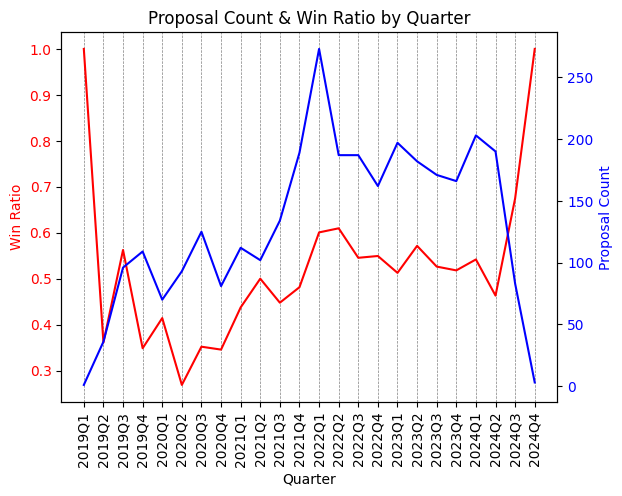

In [1550]:
#Summarize the win/loss ratio by month
prop['quarter'] = prop['issued_date'].dt.to_period('Q')
grouped = prop.groupby('quarter')['outcome'].agg(['mean', 'count'])

#Plot results
fig, ax = plt.subplots()
ax.plot(grouped.index.astype(str), grouped['mean'], color='red')
ax.set_xlabel('Quarter')
ax.set_ylabel('Win Ratio', color='red')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(grouped.index.astype(str), grouped['count'], color='blue')
ax2.set_ylabel('Proposal Count', color = 'blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.grid(True, axis='x', linestyle='--', color='gray', linewidth=0.5)
ax.set_title('Proposal Count & Win Ratio by Quarter')
plt.show()

Proposal count and win rate both increased around 2021 Q4. Will keep this in mind during EDA to see if there is a change in proposal composition around this time. By 2022 Q1 and later the win ratio is relatively stable.

# **region - keep**

These values were obtained by taking the first two digits of the client IDs. In the case of condominium corporations, these first two digits represent the region of the registry office that the building is in. We will be able to use these as a region indicator and use them to isolate regions within Ontario such as Toronto

In [1551]:
print(prop['registry_region'].value_counts(dropna=False))

registry_region
TS    454
YR    264
OC    206
MT    199
PC    181
     ... 
Nu      1
Ts      1
I.      1
L'      1
Ic      1
Name: count, Length: 290, dtype: int64


This column is messy. Doing some minor cleanup here before we test significance.

In [1552]:
#The true region indicators are the ones that are two capital letters
prop = prop[(prop['registry_region'].str.len() == 2) & (prop['registry_region'].str.isupper())]
print(prop['registry_region'].value_counts(dropna=False))

registry_region
TS    454
YR    264
OC    206
MT    199
PC    181
     ... 
CP      1
SH      1
GO      1
TJ      1
SM      1
Name: count, Length: 114, dtype: int64


At a high level there does seem to be a difference in win rate for toronto (41 percent) vs the rest of Ontario (51 percent)

In [1553]:
#Toronto outcome df
toronto = prop[prop['registry_region'].isin(['MT', 'TS'])]['outcome']

print(toronto.describe())
print('win rate: ', np.mean(toronto))
print(toronto.shape)

count   653.000000
mean      0.410413
std       0.492286
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
Name: outcome, dtype: float64
win rate:  0.4104134762633997
(653,)


In [1554]:
#Non-Toronto outcome df
other = prop[~prop['registry_region'].isin(['MT', 'TS'])]['outcome']

print(other.describe())
print('win rate: ', np.mean(other))
print(other.shape)

count   1638.000000
mean       0.509158
std        0.500069
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: outcome, dtype: float64
win rate:  0.5091575091575091
(1638,)


Hypothesis: There is no difference in win-rate for Toronto vs the rest of Ontario

In [1555]:
sample_a = other
sample_b = toronto

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.0


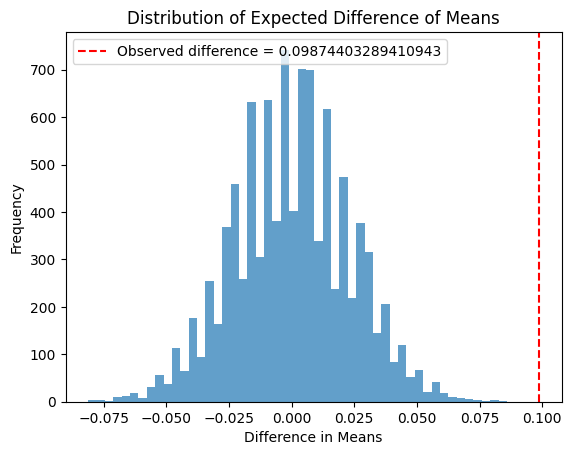

In [1556]:
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

Region definitely impacts proposla outcome.  We'll want to use it as a feature

To make this more useable, Registry Offices will be grouped by region

In [1557]:
#Import the mapping table for region & registry offices
from google.colab import files
uploaded = files.upload()

for filename, file_content in uploaded.items():
   region = pd.read_excel(io.BytesIO(file_content))

print(region.shape)

Saving 1.2 Region Mapping.xlsx to 1.2 Region Mapping (9).xlsx
(55, 11)


In [1558]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LRO Acronym                  55 non-null     object 
 1   Land Registry Office         55 non-null     object 
 2   Land Registry Office Number  55 non-null     object 
 3   LRO Street                   55 non-null     object 
 4   Town                         55 non-null     object 
 5   Prov                         55 non-null     object 
 6   Postal                       55 non-null     object 
 7   LRO Tel                      55 non-null     object 
 8   LRO Fax                      55 non-null     object 
 9   CCI Chapter                  55 non-null     object 
 10  Estimated # of Condos        53 non-null     float64
dtypes: float64(1), object(10)
memory usage: 4.9+ KB


In [1559]:
#drop all columns except LRO Acronym and CCI Chapter
region = region[['LRO Acronym', 'CCI Chapter']]

#rename CCI Chapter to region
region.rename(columns={'CCI Chapter': 'region'}, inplace=True)

region.describe()

,LRO Acronym,region
count,55,55
unique,55,8
top,AC,EO
freq,1,17


In [1560]:
#create a region column in prop
print(prop.shape)
prop = pd.merge(prop, region, left_on='registry_region', right_on = 'LRO Acronym', how='left')
print(prop.shape)

(2291, 23)
(2291, 25)


In [1561]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291 entries, 0 to 2290
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   proposal_num     2273 non-null   object        
 1   registry_region  2291 non-null   object        
 2   sow              2287 non-null   object        
 3   rfp              43 non-null     object        
 4   units_orig       2156 non-null   object        
 5   storeys_orig     2090 non-null   object        
 6   townhouse_orig   2026 non-null   object        
 7   parking_orig     2041 non-null   object        
 8   prev_rfs         2280 non-null   object        
 9   reminder         2286 non-null   object        
 10  fee_probable     2227 non-null   float64       
 11  issued_date      2227 non-null   datetime64[ns]
 12  outcome          2291 non-null   int64         
 13  prev_wins        2291 non-null   float64       
 14  townhouse_flag   2291 non-null   float64

In [1562]:
#drop LRO Acronym column
prop.drop(columns=['LRO Acronym'], inplace=True)

In [1563]:
prop['region'].describe()

,region
count,1889
unique,7
top,TOR
freq,1232


In [1564]:
prop['region'].value_counts(dropna=False)

,count
region,
TOR,1232
NaN,402
EO,283
HUR,247
GH,95
GR,13
LON,13
WIN,6


Nulls

Some of these nulls are to be expected since the proposal is under the name of the client rather than registry office (H&R for example).

In [1565]:
#display unique registry_office values where region is null
print(prop[prop['region'].isna()]['registry_region'].value_counts())

registry_region
H&    142
CA     61
TC     43
BG     33
CH     11
     ... 
WC      1
SH      1
GO      1
TJ      1
SM      1
Name: count, Length: 74, dtype: int64


In [1566]:
#Adding some of the older region mappings in
prop.loc[prop['registry_region'] == 'CA', 'region'] = 'EO'

In [1567]:
#% of nulls in the region column
print(prop['region'].isna().mean())

0.14884329986905281


We're not able to interpolate region, so we'll set all remaining region nulls to 'Unknown'

In [1568]:
#where region is null, set value to Unknown
prop.loc[prop['region'].isna(), 'region'] = 'Unknown'

In [1569]:
prop['region'].value_counts(dropna=False)

,count
region,
TOR,1232
EO,344
Unknown,341
HUR,247
GH,95
GR,13
LON,13
WIN,6


Quick test to confirm the Toronto region impact on outcome is still seen with the new region grouping

In [1570]:
toronto = prop[prop['region'].isin(['TOR'])]['outcome']
other = prop[~prop['region'].isin(['TOR'])]['outcome']

In [1571]:
sample_a = other
sample_b = toronto

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.0


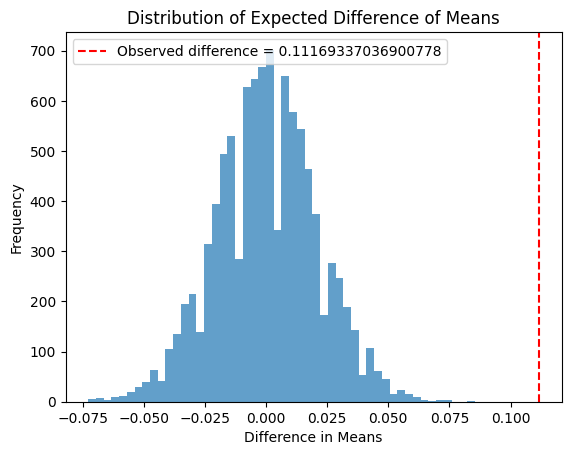

In [1572]:
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

# **rfp - discard**

This column indicates whether the proposal was submitted in response to a Request for Proposals.

In [1573]:
prop['rfp'].value_counts(dropna=False)

,count
rfp,
NaN,2248
CPR-2024-001,7
23030,2
23-467-58,1
1094776,1
23-440-31,1
23-460-51,1
23-459-50,1
23-464-55,1


In [1574]:
#Currently the values in the column are rfp IDs where non-rfp proposals are null. We will convert this to a flag where 1 = rfp and 0 = no rfp
prop['rfp'] = np.where(prop['rfp'].str.len() > 0, 1, 0)
print(prop['rfp'].value_counts())

rfp
0    2248
1      43
Name: count, dtype: int64


Very few of the proposals are rfps. We may want to exclude these proposals, or not use the flag as a feature. Lets explore:

In [1575]:
no_rfp = prop[prop['rfp'] == 0]
rfp = prop[prop['rfp'] == 1]

pd.set_option('display.float_format', '{:.6f}'.format)

print('no rfp:', no_rfp[['fee_probable', 'outcome']].describe())
print('rfp:', rfp[['fee_probable', 'outcome']].describe())

no rfp:        fee_probable     outcome
count   2185.000000 2248.000000
mean    6794.650801    0.481762
std    24428.553828    0.499778
min        0.000000    0.000000
25%     2395.000000    0.000000
50%     3262.000000    0.000000
75%     4995.000000    1.000000
max   598770.000000    1.000000
rfp:        fee_probable   outcome
count     42.000000 43.000000
mean   65325.319524  0.441860
std    58393.800770  0.502486
min        0.000000  0.000000
25%    22125.000000  0.000000
50%    45769.500000  0.000000
75%    89475.000000  1.000000
max   286425.000000  1.000000


The rfp proposals are generally much larger than a regular proposal with an average probable fee of 147k vs 11k for non-rfp proposals. They are also missing some information, with only 97 rfp proposals containing probable fee information


Even when we break down the differences by project type, the rfp proposals are generally worth quite a bit more than the non-rfp projects. They also have a lower success rate.

In [1576]:
rfp = prop[prop['rfp'] == 1]
no_rfp = prop[prop['rfp'] == 0]

rfp_grouped = rfp.groupby(['project_type'])['fee_probable'].agg(['mean', 'median', 'count'])
print('rfp:', rfp_grouped)

no_rfp_grouped = no_rfp.groupby(['project_type'])['fee_probable'].agg(['mean', 'median', 'count'])
print('rfp:', no_rfp_grouped)

rfp:                      mean       median  count
project_type                                 
Assessment   72264.593077 51500.000000     26
Consult      43150.000000 43150.000000      2
Envelope     62457.416667 53750.000000     12
RFS           4995.000000  4995.000000      1
rfp:                      mean      median  count
project_type                                
AA            4295.000000 4295.000000      1
Assessment   16624.148289 4490.000000    263
Consult       7715.424581 3850.000000    179
Envelope     13477.582278 4700.000000    237
Mechanical    6101.555556 3200.000000     45
RFS           3827.677328 2995.000000   1407


In [1577]:
print('rfp:', rfp.groupby('project_type')['outcome'].agg(['mean']))
print('no rfp:', no_rfp.groupby('project_type')['outcome'].agg(['mean']))

rfp:                  mean
project_type         
Assessment   0.576923
Consult      0.000000
Envelope     0.153846
RFS          1.000000
no rfp:                  mean
project_type         
AA           1.000000
Assessment   0.613383
Consult      0.446809
Envelope     0.550201
Mechanical   0.617021
RFS          0.444599


I recommend removing the rfp-based proposals from the dataset. They are a very small subset making up less than 4% of the proposals, and they are abnormal in terms of size and outcome

# **project_type - keep**

A categorization of the type of project the proposal pertains to. The type of information available in this data is also dependent on project_type

At a very high level, it appears the likelihood of a proposal being successful varies by project type

In [1578]:
prop.groupby('project_type')['outcome'].agg(['mean', 'count'])

,mean,count
project_type,,
AA,1.000000,1
Assessment,0.610169,295
Consult,0.442105,190
Envelope,0.530534,262
Mechanical,0.617021,47
RFS,0.444986,1436


Hypthesis: There is no difference in outcome between Assessment and RFS projects

In [1579]:
sample_a = prop[prop['project_type'] == 'Assessment']['outcome']
sample_b = prop[prop['project_type'] == 'RFS']['outcome']

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.0


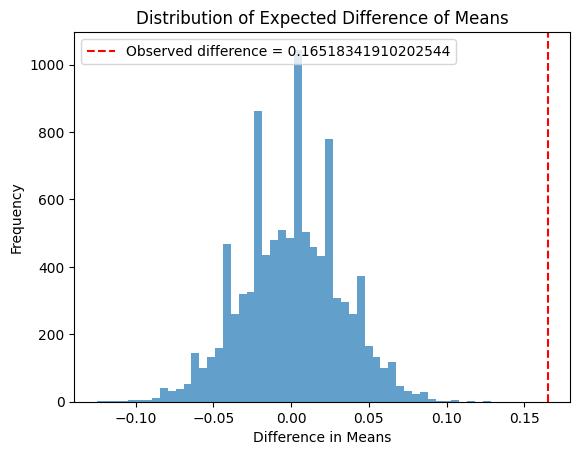

In [1580]:
import matplotlib.pyplot as plt
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

project_type has an impact on proposal outcome. We will carry this feature over into our analysis

Nulls

There are a few nulls in this column. The sow column may help to fill this in so we'll revisit in that section

In [1581]:
prop['project_type'].isna().sum()

60

# **fee_probable - first pass - inconclusive**

This column contains the expected project value that would be received if the project is won. This reflects the fee proposed in the proposal, and does not reflect any adjustments made after the final proposal is submitted.

There is a huge amount of variation in this variable. The IQR is tight, ranging from 2500 to 7000, but the standard deviation is a massive 78,000. There are some extremely large values skewing this data

In [1582]:
prop['fee_probable'].describe()

,fee_probable
count,2227.000000
mean,7898.507149
std,26678.059574
min,0.000000
25%,2400.000000
50%,3295.000000
75%,5142.500000
max,598770.000000


Removing 0s

In [1583]:
prop['fee_probable'].replace(0, np.nan, inplace=True)

<ipython-input-1583-f0502e293278>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prop['fee_probable'].replace(0, np.nan, inplace=True)


Nulls

In [1584]:
prop['fee_probable'].isna().sum()

66

Distribution

The data is similar to an exponential distribution, but is more extreme.

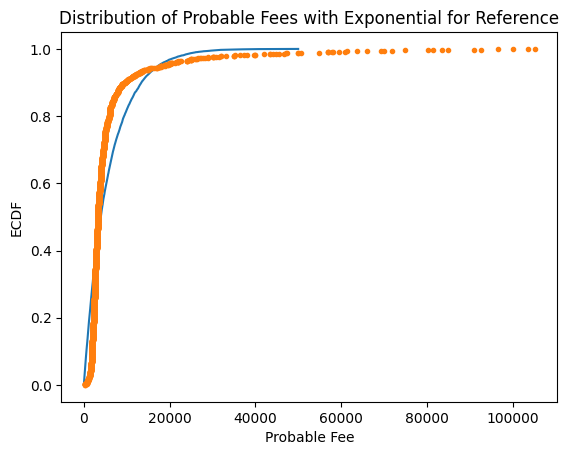

In [1585]:
#Exponential Distribution Comparison
# The top results are extreme, so they will be removed before running the distribution
percentile_99 = np.nanpercentile(prop['fee_probable'], 99)
filtered_prop = prop[prop['fee_probable'] <= percentile_99]
filtered_prop = filtered_prop.dropna(subset=['fee_probable'])

rng = np.random.default_rng()

mean = np.mean(filtered_prop['fee_probable'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(filtered_prop['fee_probable'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Probable Fees with Exponential for Reference')
plt.show()

Log Transformation

Converting the fee_probable with a log transformation does not work well because the data is so heavily skewed. It helps to reign in the larger values, but comresses the already dense majority

In [1586]:
log_fee_probable = np.log1p(prop['fee_probable'])
log_fee_probable.dropna(inplace=True)

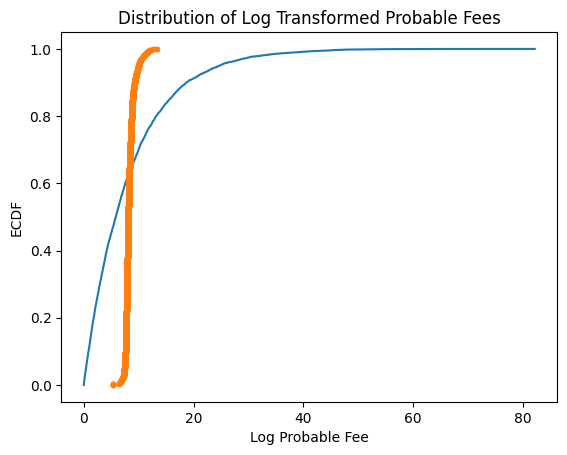

In [1587]:
mean = np.mean(log_fee_probable)
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(log_fee_probable)
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Log Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Log Transformed Probable Fees')
plt.show()

Square Root Transformation

This does a better job of converting the data than log, but it is still extremely clustered to the left

In [1588]:
sqrt_fee_probable = np.sqrt(prop['fee_probable'])
sqrt_fee_probable.dropna(inplace=True)

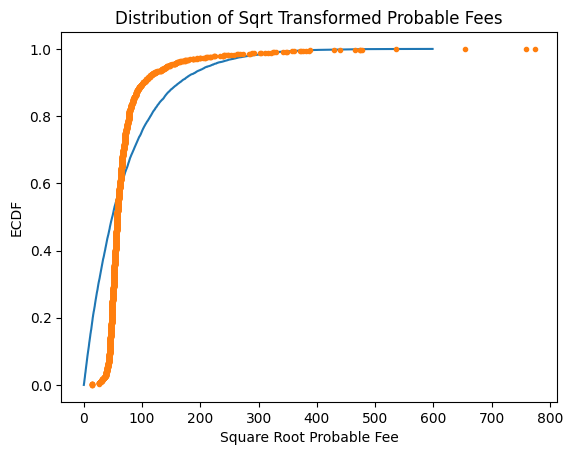

In [1589]:
mean = np.mean(sqrt_fee_probable)
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(sqrt_fee_probable)
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Square Root Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Sqrt Transformed Probable Fees')
plt.show()

Variation in fee by project type

The different project types likely have a different spread in terms of fee_probable. Taking this into account might help make sense of the fee distribution

There are definitely differences by project type. RFS (reserve fund studies) are much more cententrated at lower values, while Assessments are much more spread out. That said, all project types have an extremely condensed IQR and large std. There may not be enough variation in this value to be useful

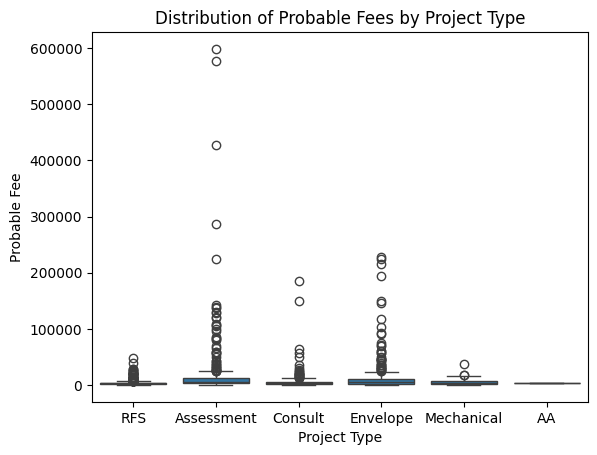

In [1590]:
_ = sns.boxplot(x='project_type',y='fee_probable', data = prop)
_ = plt.xlabel('Project Type')
_ = plt.ylabel('Probable Fee')
_ = plt.title('Distribution of Probable Fees by Project Type')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [1591]:
#IQR of fee_probable by project_type
rfs = prop[prop['project_type'] == 'RFS']
assessment = prop[prop['project_type'] == 'Assessment']
consult = prop[prop['project_type'] == 'Consult']
envelope = prop[prop['project_type'] == 'Envelope']
mechanical = prop[prop['project_type'] == 'Mechanical']
AA = prop[prop['project_type'] == 'AA']

print('rfs:', rfs['fee_probable'].describe())
print('assessment:', assessment['fee_probable'].describe())
print('consult:', consult['fee_probable'].describe())
print('envelope:', envelope['fee_probable'].describe())
print('mechanical:', mechanical['fee_probable'].describe())

rfs: count    1408.000000
mean     3828.506392
std      3116.883373
min       932.000000
25%      2395.000000
50%      2997.500000
75%      4195.000000
max     47285.000000
Name: fee_probable, dtype: float64
assessment: count      287.000000
mean     21780.593798
std      62798.123997
min        195.000000
25%       3038.500000
50%       5000.000000
75%      11645.000000
max     598770.000000
Name: fee_probable, dtype: float64
consult: count      181.000000
mean      8106.966851
std      19103.045109
min        195.000000
25%       1995.000000
50%       3885.000000
75%       6000.000000
max     184700.000000
Name: fee_probable, dtype: float64
envelope: count      249.000000
mean     15838.056225
std      33516.856196
min        195.000000
25%       2650.000000
50%       4950.000000
75%      11245.000000
max     228013.000000
Name: fee_probable, dtype: float64
mechanical: count      45.000000
mean     6101.555556
std      6939.983202
min       195.000000
25%      1950.000000
50%      32

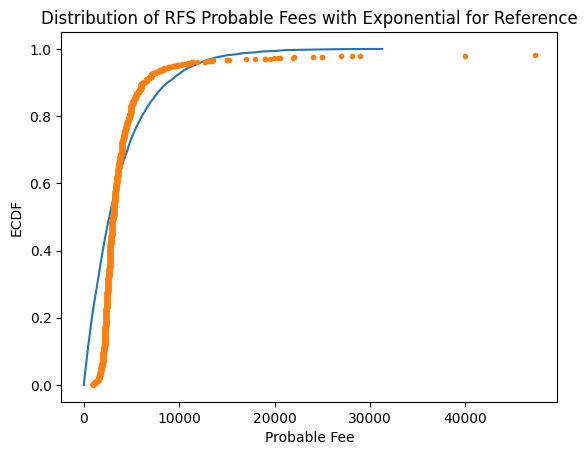

In [1592]:
mean = np.mean(rfs['fee_probable'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(rfs['fee_probable'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of RFS Probable Fees with Exponential for Reference')
plt.show()

**Distribution of fee_probable by Project Type**

**RFS**

RFS fee_probable is still extremely clustered to the left

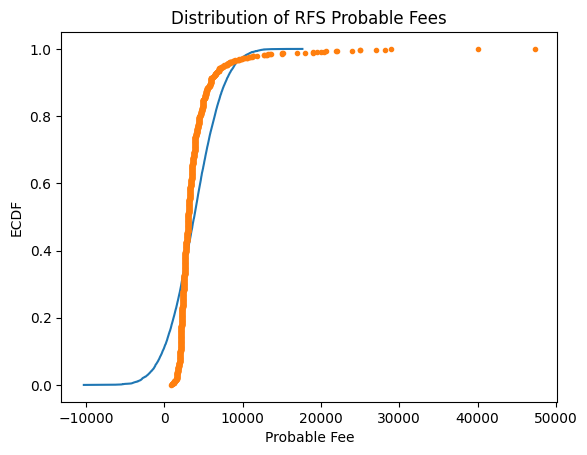

In [1593]:
#Normal Distribution
filtered_prop = prop[prop['project_type'] == 'RFS']
filtered_prop = filtered_prop.dropna(subset=['fee_probable'])

rng = np.random.default_rng()

mean = np.mean(filtered_prop['fee_probable'])
std = np.std(filtered_prop['fee_probable'])
samples = rng.normal(mean, std, size=10000)
x, y  = ecdf(filtered_prop['fee_probable'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of RFS Probable Fees')
plt.show()

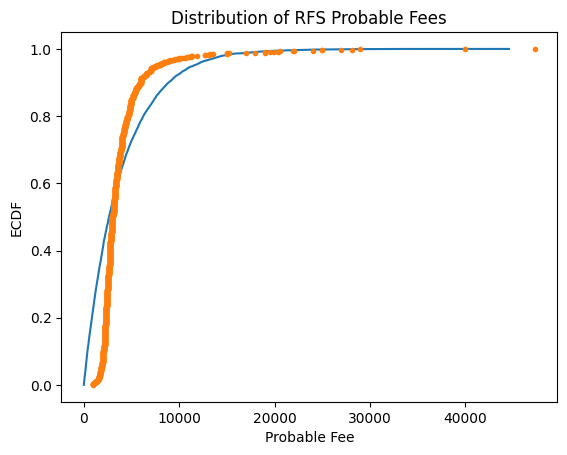

In [1594]:
#Exponential (no transformation)
mean = np.mean(filtered_prop['fee_probable'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(filtered_prop['fee_probable'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of RFS Probable Fees')
plt.show()

Since the project type starts to explain the distribution but still has too much clustering to be described, our project groupings are probably not specific enough.

In [1595]:
#print unique values in sow column that contain the text 'rfs' in them
prop['sow'].unique()

array(['Update RFS', 'Class 2 RFS', 'Class 3 RFS', 'Class 1 RFS',
       'PA1, C1, PA2', 'C2 RFS with C3 Fee', 'PA & Class 1 RFS',
       'Consult', 'BCA & RFS', nan, 'PA1&2 Follow Up; C2 RFS',
       'PA Year 2', 'PA Year 1', 'PA Follow-Up', 'BCA', 'Roofing',
       'Garage ', 'Stairs', 'Envelope', 'Pavement', 'PA Year 7', 'PCA',
       'Balcony', 'Windows', 'Renovation', 'Mechanical', 'Doors',
       'Sealants', 'Landscaping ', 'Structural', 'PPA', 'Electrical',
       'Accessibility Audit'], dtype=object)

Let's start with the Class 3 RFS

In [1596]:
rfs_c3 = rfs[rfs['sow'].isin([ 'Class 3 RFS', 'Update RFS'])]

#drop null rfs_c3 probable fees
rfs_c3 = rfs_c3.dropna(subset=['fee_probable'])

print(rfs_c3.shape)
rfs_c3.describe()

(463, 24)


,rfp,fee_probable,issued_date,outcome,prev_wins,townhouse_flag,storeys,comm_flag,comm_units,potl_units,res_units,building_age
count,463.000000,463.000000,463,463.000000,463.000000,463.000000,248.000000,463.000000,75.000000,38.000000,321.000000,428.000000
mean,0.000000,2893.861771,2022-01-01 07:24:45.097192192,0.634989,0.442765,0.246220,13.072581,0.146868,27.946667,46.710526,111.140187,23.450935
min,0.000000,950.000000,2019-03-22 00:00:00,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,6.000000,3.000000,0.000000
25%,0.000000,2195.000000,2020-08-17 12:00:00,0.000000,0.000000,0.000000,3.000000,0.000000,8.000000,22.250000,26.000000,11.000000
50%,0.000000,2495.000000,2022-01-06 00:00:00,1.000000,0.000000,0.000000,4.000000,0.000000,19.000000,45.000000,54.000000,19.000000
75%,0.000000,3395.000000,2023-04-27 12:00:00,1.000000,1.000000,0.000000,16.000000,0.000000,35.500000,53.750000,148.000000,35.000000
max,0.000000,8395.000000,2024-10-03 00:00:00,1.000000,5.000000,1.000000,637.000000,1.000000,178.000000,150.000000,616.000000,53.000000
std,0.000000,1144.662580,NaN,0.481954,0.658335,0.431274,42.645165,0.354357,32.254433,32.872323,126.917748,15.398529


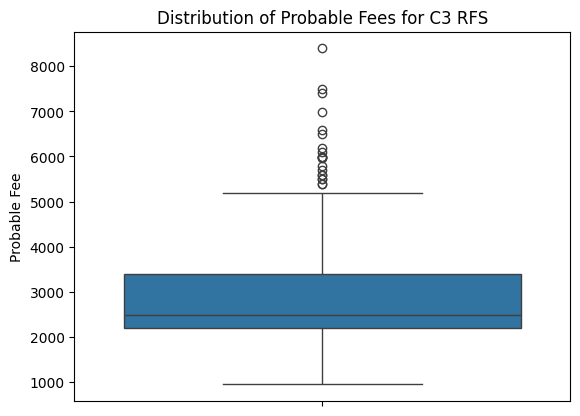

In [1597]:
_ = sns.boxplot(y='fee_probable', data = rfs_c3)
_ = plt.ylabel('Probable Fee')
_ = plt.title('Distribution of Probable Fees for C3 RFS')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

This is more reasonable, even if still clustered a bit! Given this, we will revisit the project_type groupings

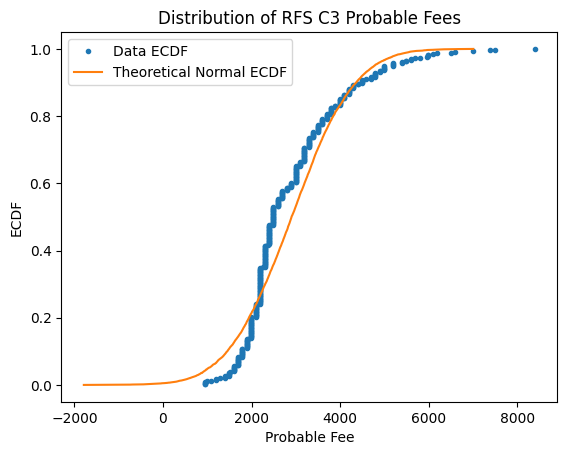

In [1598]:
mean = np.mean(rfs_c3['fee_probable'])
std_dev = np.std(rfs_c3['fee_probable'])
samples = rng.normal(mean, std_dev, size=10000)

ecdf_data = ECDF(rfs_c3['fee_probable'])
ecdf_samples = ECDF(samples)

_ = plt.plot(ecdf_data.x, ecdf_data.y, label='Data ECDF', marker = '.', linestyle = 'none')
_ = plt.plot(ecdf_samples.x, ecdf_samples.y, label='Theoretical Normal ECDF')
_ = plt.xlabel('Probable Fee')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of RFS C3 Probable Fees')
_ = plt.legend()
_ = plt.show()

# **sow / project_type**

This is the detailed (ungrouped) project_type classification. SOW = Statement of Work

In [1599]:
prop['sow'].value_counts(dropna=False)

,count
sow,
Class 2 RFS,835
Update RFS,453
Consult,190
Roofing,111
Garage,94
PCA,92
PA & Class 1 RFS,85
BCA,68
Envelope,67


There's a lot here so we're going to go by project_type to see how the different sows in each behave

We will deal with outliers at the end of this section once we have finished recategorizing

**RFS**

In [1600]:
#value counts of sow from the prop df where project_type = rfs
print(prop['sow'][prop['project_type'] == 'RFS'].value_counts(dropna=False))
print(rfs['sow'].value_counts(dropna=False))

sow
Class 2 RFS         835
Update RFS          453
PA & Class 1 RFS     85
Class 1 RFS          42
Class 3 RFS          16
BCA & RFS             5
Name: count, dtype: int64
sow
Class 2 RFS         835
Update RFS          453
PA & Class 1 RFS     85
Class 1 RFS          42
Class 3 RFS          16
BCA & RFS             5
Name: count, dtype: int64


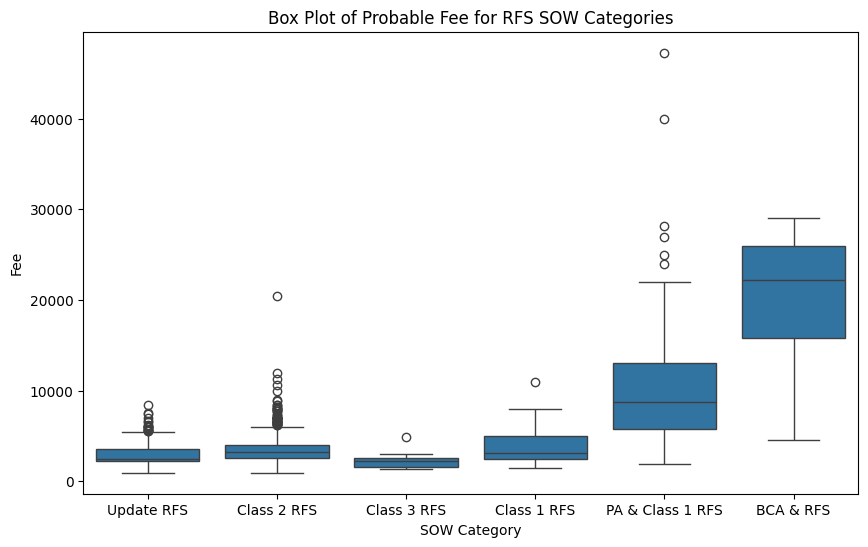

In [1601]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=rfs)

plt.title("Box Plot of Probable Fee for RFS SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

Based on this, we'll remove 'PA & Class 1 RFS' and 'BCA & RFS' from the RFS project_type, and we'll keep the others grouped

In [1602]:
#where sow = PA & Class 1 RFS, change project_type to PA & Class 1 RFS
prop.loc[prop['sow'] == 'PA & Class 1 RFS', 'project_type'] = 'PA & Class 1 RFS'
prop.loc[prop['sow'] == 'BCA & RFS', 'project_type'] = 'BCA & RFS'

#remove 'PA & Class 1 RFS' and 'BCA & RFS' sow types from rfs
rfs = rfs[~rfs['sow'].isin(['PA & Class 1 RFS', 'BCA & RFS'])]

In [1603]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1346
Assessment,295
Envelope,262
Consult,190
PA & Class 1 RFS,85
NaN,60
Mechanical,47
BCA & RFS,5
AA,1


**Assessment**

In [1604]:
#value counts of sow from the prop df where project_type = assessment
print(prop['sow'][prop['project_type'] == 'Assessment'].value_counts(dropna=False))
print(assessment['sow'].value_counts(dropna=False))

sow
Garage          94
PCA             92
BCA             68
PA1, C1, PA2    25
PA Year 7        7
PA Follow-Up     4
PPA              4
PA Year 1        1
Name: count, dtype: int64
sow
Garage          94
PCA             92
BCA             68
PA1, C1, PA2    25
PA Year 7        7
PA Follow-Up     4
PPA              4
PA Year 1        1
Name: count, dtype: int64


These categories are all quite different. We'll remove the Assessment category from the projects altogether

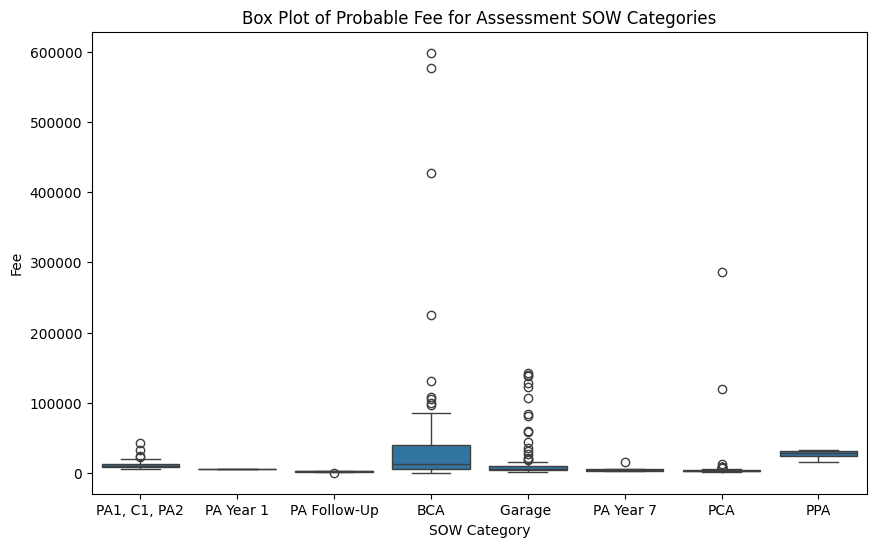

In [1605]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=assessment)

plt.title("Box Plot of Probable Fee for Assessment SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

In [1606]:
#Remove trailing spaces causing duplicate sow categories
assessment['sow'] = assessment['sow'].str.strip()
prop['sow'] = prop['sow'].str.strip()

<ipython-input-1606-4d71fb6991ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessment['sow'] = assessment['sow'].str.strip()


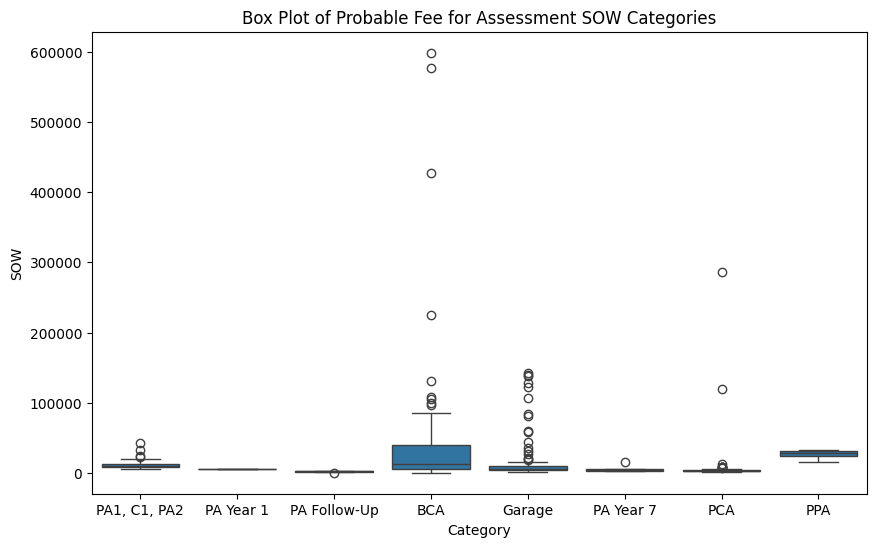

In [1607]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=assessment)

plt.title("Box Plot of Probable Fee for Assessment SOW Categories")
plt.xlabel("Category")
plt.ylabel("SOW")

plt.show()

BCA and Garage have the quantity and varaince to be their own categories

In [1608]:
#Change BCA and Garage project_types
prop.loc[prop['sow'] == 'BCA', 'project_type'] = 'BCA'
prop.loc[prop['sow'] == 'Garage', 'project_type'] = 'Garage'

#remove 'BCA' and 'Garage' sow types from assessments
assessment = assessment[~assessment['sow'].isin(['BCA', 'Garage'])]

assessment['sow'].value_counts(dropna=False)

,count
sow,
PCA,92
"PA1, C1, PA2",25
PA Year 7,7
PA Follow-Up,4
PPA,4
PA Year 1,1


In [1609]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1346
Envelope,262
Consult,190
Assessment,133
Garage,94
PA & Class 1 RFS,85
BCA,68
NaN,60
Mechanical,47


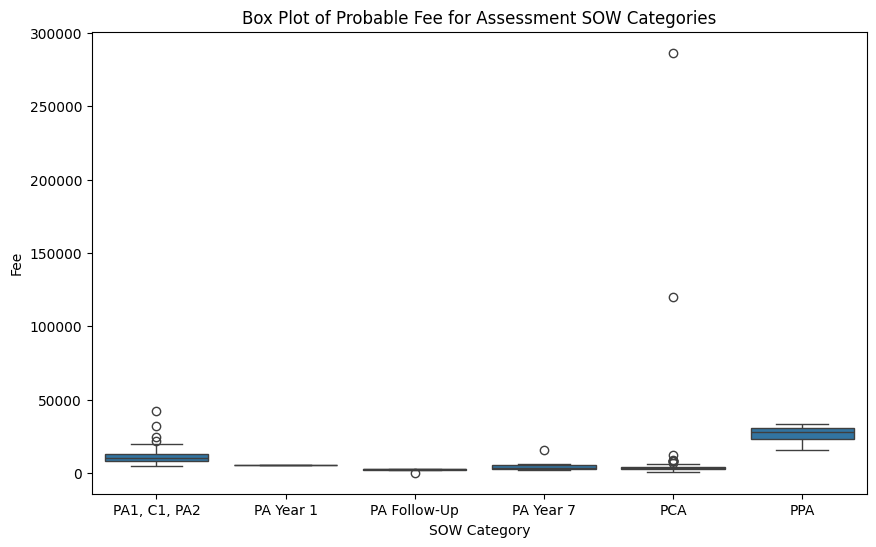

In [1610]:
#Plot remaining Assessment sow types
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=assessment)

plt.title("Box Plot of Probable Fee for Assessment SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

We'll group PA Year 1, PA Follow-Up and PA Year 7. The other categories will be on their own

In [1611]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1346
Envelope,262
Consult,190
Assessment,133
Garage,94
PA & Class 1 RFS,85
BCA,68
NaN,60
Mechanical,47


In [1612]:
#Create a new PA group
prop.loc[prop['sow'] == 'PA Year 1', 'project_type'] = 'PA'
prop.loc[prop['sow'] == 'PA Follow-Up', 'project_type'] = 'PA'
prop.loc[prop['sow'] == 'PA Year 7', 'project_type'] = 'PA'

In [1613]:
#Set PCA to its own category since it has almost 100 proposals in it
prop.loc[prop['sow'] == 'PCA', 'project_type'] = 'PCA'

In [1614]:
#Set the unique, low-count others to Other
prop.loc[prop['sow'].isin(['PA1, C1, PA2', 'PPA']), 'project_type'] = 'Other'

In [1615]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1346
Envelope,262
Consult,190
Garage,94
PCA,92
PA & Class 1 RFS,85
BCA,68
NaN,60
Mechanical,47


**Envelope**

In [1616]:
print(prop['sow'][prop['project_type'] == 'Envelope'].value_counts(dropna=False))
print(envelope['sow'].value_counts(dropna=False))

sow
Roofing       111
Envelope       67
Balcony        35
Structural     25
Windows        13
Sealants        6
Stairs          4
Doors           1
Name: count, dtype: int64
sow
Roofing       111
Envelope       67
Balcony        35
Structural     25
Windows        13
Sealants        6
Stairs          4
Doors           1
Name: count, dtype: int64


We can keep most of these grouped as 'Envelope'. The categories that do vary are generally the ones with very small proposal count in them

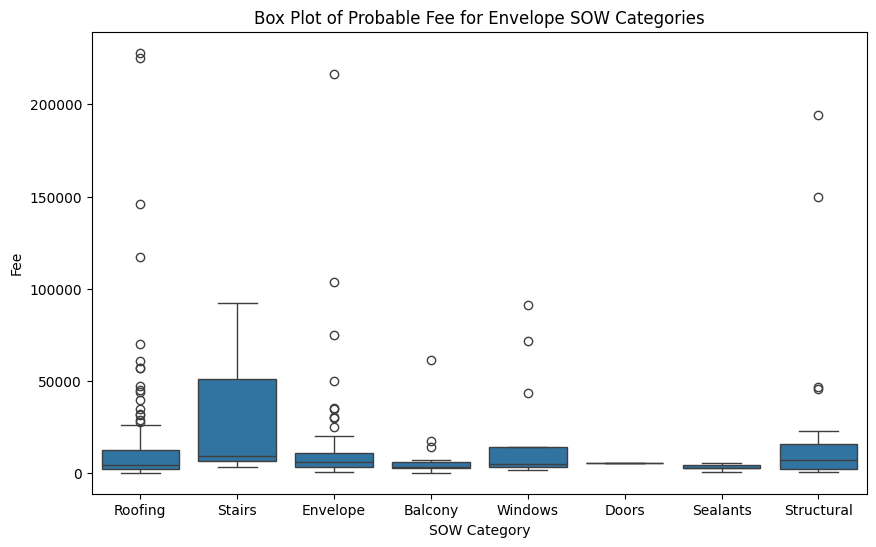

In [1617]:
#Plot Envelope project types
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=envelope)

plt.title("Box Plot of Probable Fee for Envelope SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

Roofing is a large category with 111 proposals, so we'll break that out into its own project_type

In [1618]:
prop.loc[prop['sow'] == 'Roofing', 'project_type'] = 'Roofing'

**Consult**

There are no sub-categories here to clean up, and there are enough records at 190 to justify aunique category. There are quite a few outliers for us to deal with though (will get to this at the end of the section)

In [1619]:
print(prop['sow'][prop['project_type'] == 'Consult'].value_counts(dropna=False))
print(consult['sow'].value_counts(dropna=False))

sow
Consult    190
Name: count, dtype: int64
sow
Consult    190
Name: count, dtype: int64


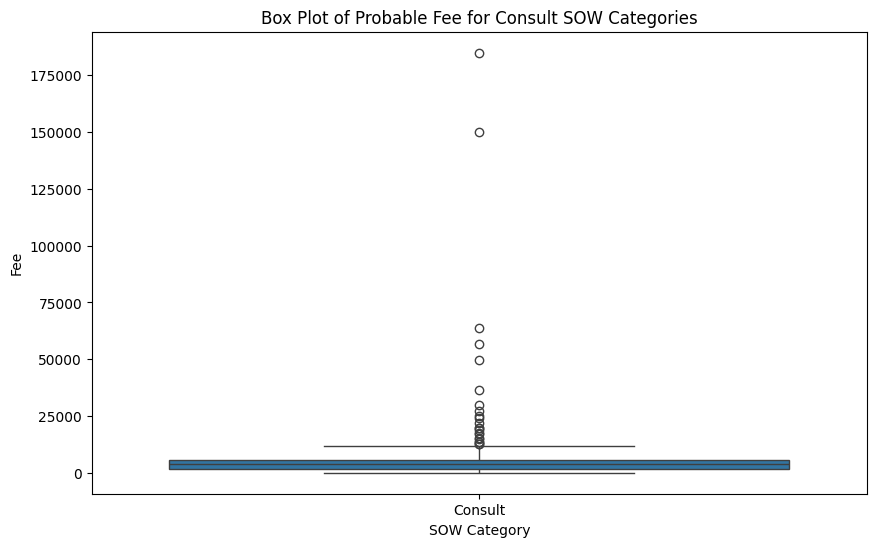

In [1620]:
#Display Consult values
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=consult)

plt.title("Box Plot of Probable Fee for Consult SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

In [1621]:
consult['fee_probable'].describe()

,fee_probable
count,181.000000
mean,8106.966851
std,19103.045109
min,195.000000
25%,1995.000000
50%,3885.000000
75%,6000.000000
max,184700.000000


**Mechanical & AA**

There are very few records in these project_types (47 and 1 respectively) and no sub-categories

In [1622]:
print(prop['sow'][prop['project_type'] == 'Mechanical'].value_counts(dropna=False))
print(mechanical['sow'].value_counts(dropna=False))

print(prop['sow'][prop['project_type'] == 'AA'].value_counts(dropna=False))
print(AA['sow'].value_counts(dropna=False))

sow
Mechanical    47
Name: count, dtype: int64
sow
Mechanical    47
Name: count, dtype: int64
sow
Accessibility Audit    1
Name: count, dtype: int64
sow
Accessibility Audit    1
Name: count, dtype: int64


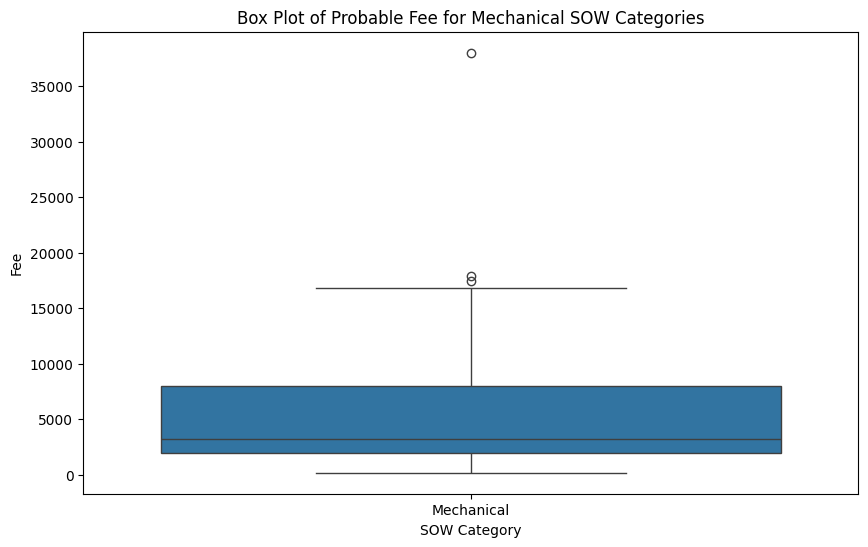

In [1623]:
#Display Mechanical values
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=mechanical)

plt.title("Box Plot of Probable Fee for Mechanical SOW Categories")
plt.xlabel("SOW Category")
plt.ylabel("Fee")

plt.show()

In [1624]:
mechanical['fee_probable'].describe()

,fee_probable
count,45.000000
mean,6101.555556
std,6939.983202
min,195.000000
25%,1950.000000
50%,3200.000000
75%,8000.000000
max,38000.000000


Since there is only 1 AA proposal we will set it to 'Other'

In [1625]:
prop.loc[prop['sow'] == 'Accessibility Audit', 'project_type'] = 'Other'

**Re-Classifed project_type check**

Check the results of our reclassification work



In [1626]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1346
Consult,190
Envelope,151
Roofing,111
Garage,94
PCA,92
PA & Class 1 RFS,85
BCA,68
NaN,60


There are some low-count categories that we shoudl look into reclassifying: PA and BCA & RFS

In [1627]:
#move PA to Other
prop.loc[prop['project_type'] == 'PA', 'project_type'] = 'Other'

In [1628]:
#Should 'BCA & RFS' be grouped with BCA or Other? This was with RFS originally
bca_type = prop[prop['project_type'].isin(['BCA & RFS', 'BCA'])]
bca_type['project_type'].value_counts()

,count
project_type,
BCA,68
BCA & RFS,5


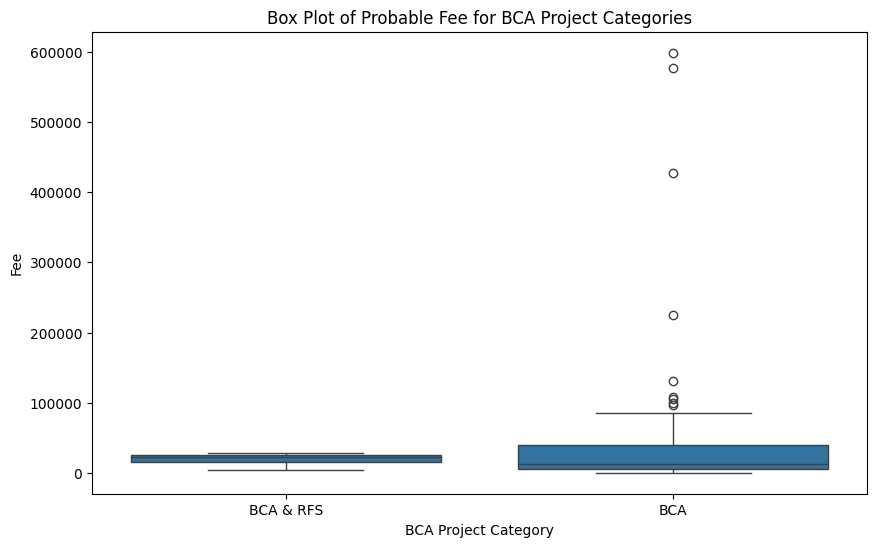

In [1629]:
#BCA vs BCA & RFS
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=bca_type)

plt.title("Box Plot of Probable Fee for BCA Project Categories")
plt.xlabel("BCA Project Category")
plt.ylabel("Fee")

plt.show()

There is a lot of overlap here, so we'll merge the two categories

In [1630]:
prop.loc[prop['project_type'] == 'BCA & RFS', 'project_type'] = 'BCA'

In [1631]:
prop['project_type'].value_counts(dropna=False)

,count
project_type,
RFS,1346
Consult,190
Envelope,151
Roofing,111
Garage,94
PCA,92
PA & Class 1 RFS,85
BCA,73
NaN,60


**Nulls**

The nulls mostly look to be very rarely used SOW codes that had no project_type mapping. These can all be assigned to Other

In [1632]:
prop['sow'][prop['project_type'].isnull()].value_counts(dropna=False)

,count
sow,
Pavement,23
Renovation,12
Landscaping,12
C2 RFS with C3 Fee,5
NaN,4
PA Year 2,2
PA1&2 Follow Up; C2 RFS,1
Electrical,1


In [1633]:
prop.loc[prop['project_type'].isnull(), 'project_type'] = 'Other'

In [1634]:
#Rows where sow is null
prop[prop['sow'].isnull()]

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,townhouse_flag,storeys,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region
429,Q200702,PT,NaN,0,NaN,NaN,NaN,NaN,No,No,...,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,Other,NaT,EO
434,NaN,HO,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,Other,NaT,Unknown
435,Q202045,TS,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,Other,NaT,TOR
438,Q202425,OC,NaN,0,6,NaN,NaN,NaN,No,No,...,0.000000,NaN,0.000000,NaN,NaN,6.000000,NaN,Other,NaT,EO


In [1635]:
#Remove these sow null rows from the data since they are null almost completely across the board
prop = prop.dropna(subset=['sow'])

**Outliers**

We're going to set a fee_probable ceiling at the 90th percentile for each category

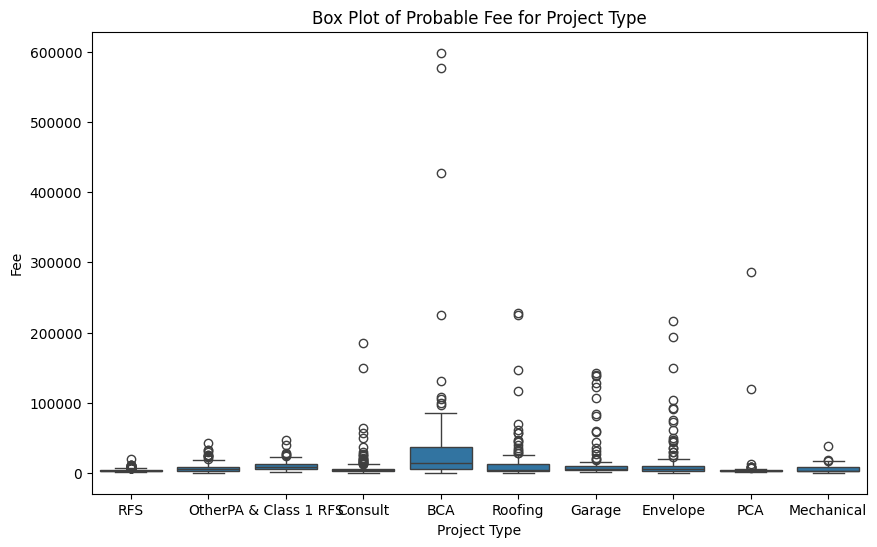

In [1636]:
#boxplot of project_type
plt.figure(figsize=(10, 6))
sns.boxplot(x='project_type', y='fee_probable', data=prop)

plt.title("Box Plot of Probable Fee for Project Type")
plt.xlabel("Project Type")
plt.ylabel("Fee")

plt.show()

In [1637]:
#calculate the 90th percentile for each project_type category
fee_percentiles = prop.groupby('project_type')['fee_probable'].quantile(0.9)
fee_percentiles

,fee_probable
project_type,
BCA,100972.200000
Consult,13500.000000
Envelope,33624.500000
Garage,56460.000000
Mechanical,14316.000000
Other,18864.000000
PA & Class 1 RFS,20410.000000
PCA,6090.500000
RFS,5195.000000


In [1638]:
#COMMENTED OUT FOR FEE_PROB EXPLORATION
#for each project_type, set any fee_probable above the project's fee_percentile to = the fee_percentile
#for project_type, fee_percentile in fee_percentiles.items():
    #prop.loc[(prop['project_type'] == project_type) & (prop['fee_probable'] > fee_percentile), 'fee_probable'] = fee_percentile

Much better! Still some outliers, but much more reasonable

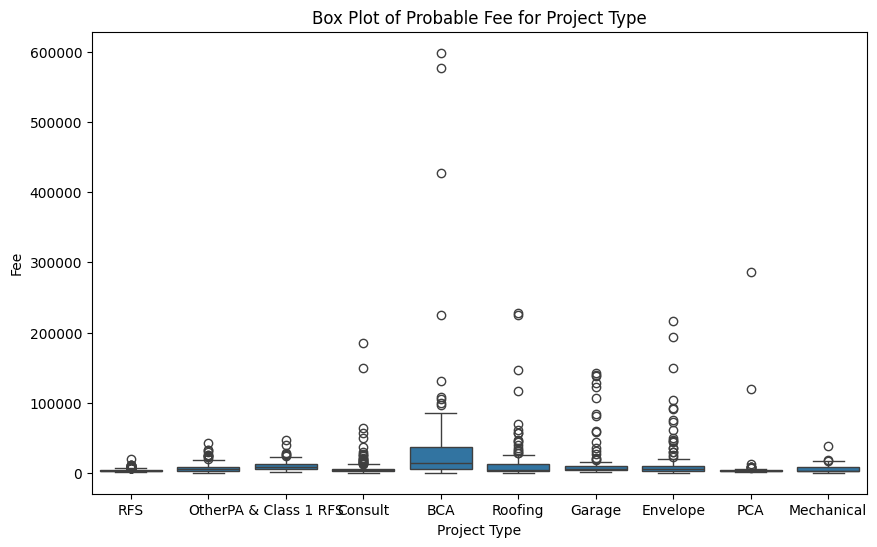

In [1639]:
#boxplot of project_types
plt.figure(figsize=(10, 6))
sns.boxplot(x='project_type', y='fee_probable', data=prop)

plt.title("Box Plot of Probable Fee for Project Type")
plt.xlabel("Project Type")
plt.ylabel("Fee")

plt.show()

# **fee_probable - second pass - discard**

Revisitng fee_probable distribution now that we've revamped our project_type classification

In [1640]:
prop['project_type'].value_counts()

,count
project_type,
RFS,1346
Consult,190
Envelope,151
Roofing,111
Other,98
Garage,94
PCA,92
PA & Class 1 RFS,85
BCA,73


**RFS**

RFS is similar to a normal distribution, but still not a complete fit

In [1641]:
rfs = prop[prop['project_type']=='RFS']

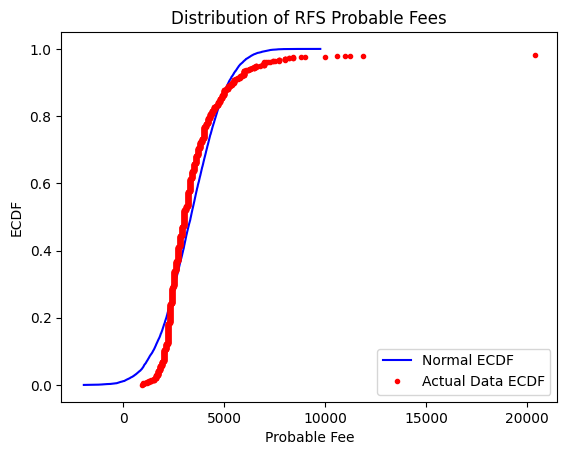

In [1642]:
#Normal Distribution
fee_probable = rfs['fee_probable']
std = np.std(fee_probable)
mean = np.mean(fee_probable)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Probable Fees')
plt.legend()
plt.show()

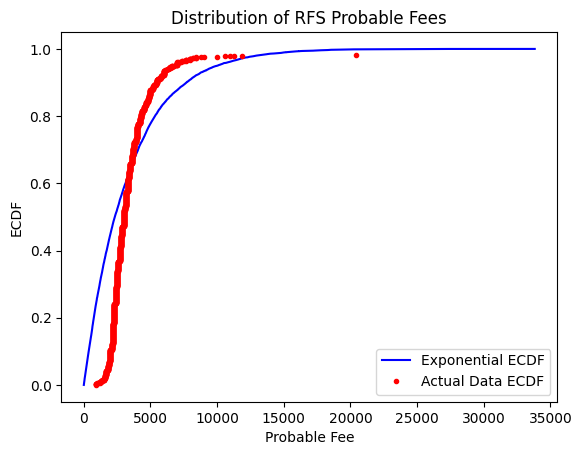

In [1643]:
#Exponential Distribution
fee_probable = rfs['fee_probable']
mean = np.mean(fee_probable)

samples = np.random.exponential(mean, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Exponential ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Probable Fees')
plt.legend()
plt.show()

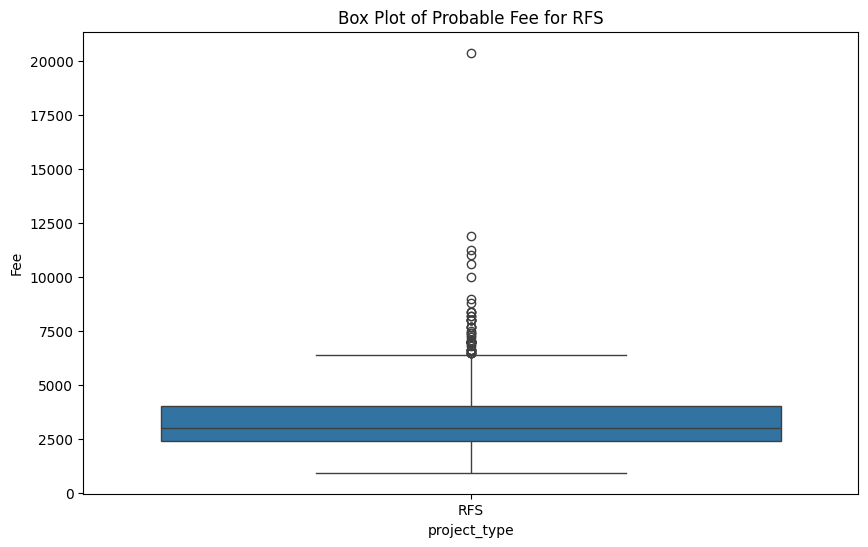

6396.875


In [1644]:
#Boxplot of RFS
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='project_type', y='fee_probable', data=rfs)

plt.title("Box Plot of Probable Fee for RFS")
plt.ylabel("Fee")

plt.show()

iqr = fee_probable.quantile(0.75) - fee_probable.quantile(0.25)
max_whisker = fee_probable.quantile(0.75) + 1.5 * iqr
print(max_whisker)

Outliers

In [1645]:
print('total outliers: ', rfs[rfs['fee_probable'] > max_whisker].shape)
print('outliers %: ', rfs[rfs['fee_probable'] > max_whisker].shape[0] / rfs.shape[0])

total outliers:  (52, 24)
outliers %:  0.03863298662704309


Lets test capping these values to the whisker max

In [1646]:
rfs_capped = rfs['fee_probable'].clip(upper=max_whisker)

The fit is close, but stil not an explainable distribution.

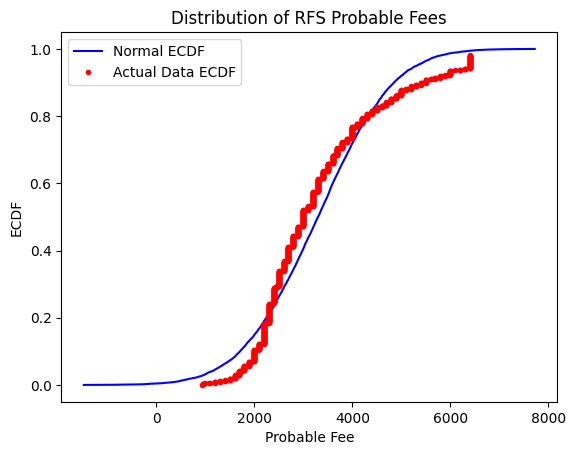

In [1647]:
#Normal Distribtuion
fee_probable = rfs_capped
std = np.std(fee_probable)
mean = np.mean(fee_probable)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Probable Fees')
plt.legend()
plt.show()

**Envelope**

In [1648]:
envelope = prop[prop['project_type']=='Envelope']

This one is still not fitting well

30987.466545064803


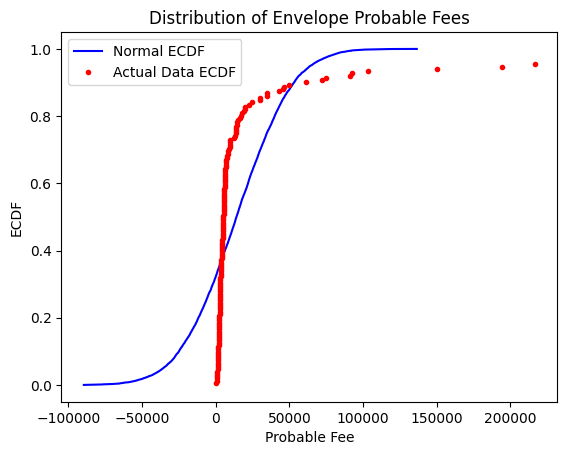

In [1649]:
#Normal Distribution
fee_probable = envelope['fee_probable']
mean = np.mean(fee_probable)
std = np.std(fee_probable)
print(std)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of Envelope Probable Fees')
plt.legend()
plt.show()

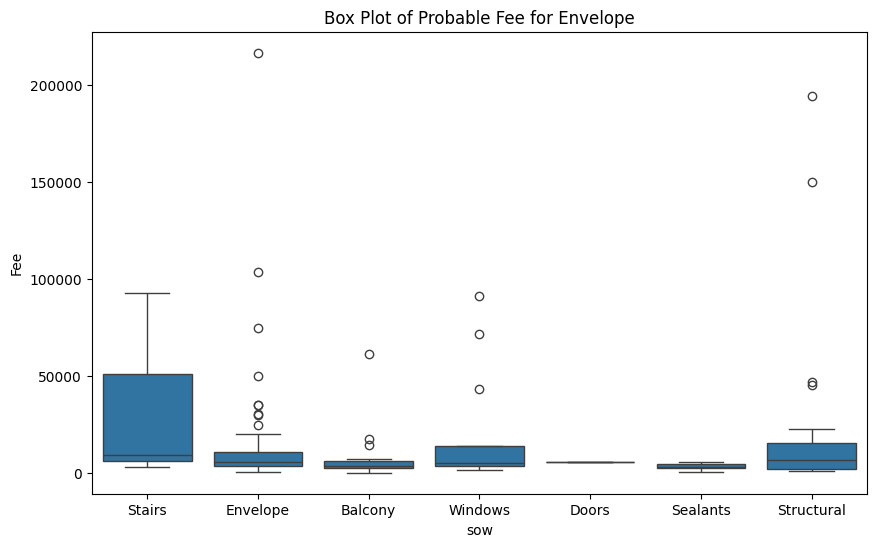

In [1650]:
#Boxplot of Envelope
plt.figure(figsize=(10, 6))
sns.boxplot(x='sow', y='fee_probable', data=envelope)

plt.title("Box Plot of Probable Fee for Envelope")
plt.ylabel("Fee")

plt.show()

In [1651]:
envelope['sow'].value_counts()

,count
sow,
Envelope,67
Balcony,35
Structural,25
Windows,13
Sealants,6
Stairs,4
Doors,1


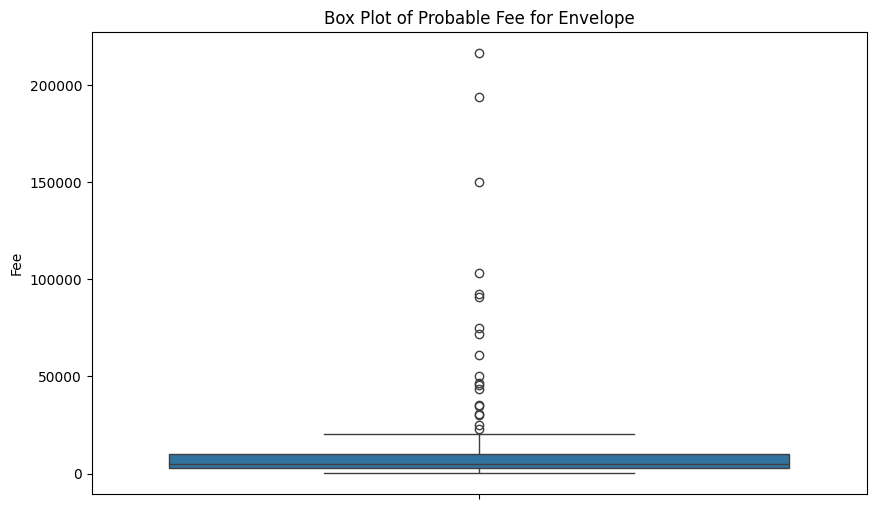

20478.75


In [1652]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='fee_probable', data=envelope)

plt.title("Box Plot of Probable Fee for Envelope")
plt.ylabel("Fee")

plt.show()

iqr = fee_probable.quantile(0.75) - fee_probable.quantile(0.25)
max_whisker = fee_probable.quantile(0.75) + 1.5 * iqr
print(max_whisker)

Outliers

There are quite a few outliers in this category. This isn't surprising given the very broad nature of the work done on these types of projects.

In [1653]:
print('total outliers: ', envelope[envelope['fee_probable'] > max_whisker].shape)
print('outliers %: ', envelope[envelope['fee_probable'] > max_whisker].shape[0] / envelope.shape[0])

total outliers:  (19, 24)
outliers %:  0.12582781456953643


We'll start with setting a category-wide cap

This doesn't do a good job of helping to explain the distribution. There is likely information that we're missing on these projects to help us appropriately categorize them (did the project only cover an assessment, or did it also include procurement to address the issues found in the assessment?)

In [1654]:
envelope_capped = envelope['fee_probable'].clip(upper=max_whisker)

6489.772903001662


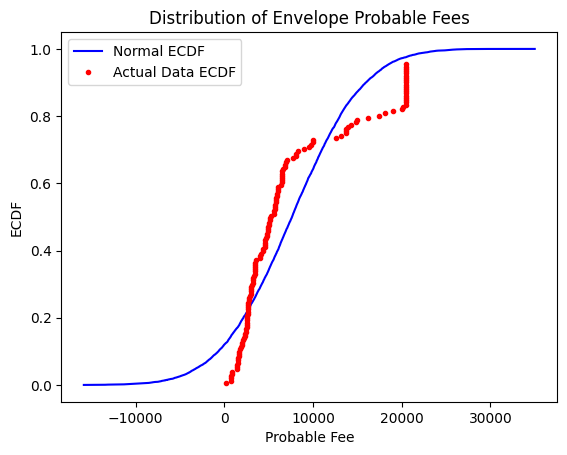

In [1655]:
#Normal Distribution
fee_probable = envelope_capped
mean = np.mean(fee_probable)
std = np.std(fee_probable)
print(std)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(fee_probable)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Probable Fee')
plt.ylabel('ECDF')
plt.title('Distribution of Envelope Probable Fees')
plt.legend()
plt.show()

In conclusion, we're unable to explain the distribution for the fee_probable column with the information that we have. Therefore this column will likely not be a factor in our analysis

# **prev_rfs & reminder - keep**

These columns are only applicable to RFS project types. Reserve Fund Studies have to be done every 3 years, so the team has included a flag for whether they did the building's previous rfs, and whether the proposal is being sent out as a reminder rather than having been asked for a quote

Since we found that project type is significant, we'll only work with rfs proposals in this section

In [1656]:
rfs = prop[prop['project_type']=='RFS']
rfs.head()

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,townhouse_flag,storeys,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region
0,Q191859,TS,Update RFS,0,NaN,NaN,NaN,NaN,Yes,No,...,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q1,TOR
1,Q202049,PC,Class 2 RFS,0,39,2,NaN,-,No,No,...,0.000000,2.000000,0.000000,NaN,NaN,39.000000,49.000000,RFS,2019Q2,TOR
2,Q201827,MT,Update RFS,0,46,5,-,-,Yes,Yes,...,0.000000,5.000000,0.000000,NaN,NaN,46.000000,NaN,RFS,2019Q2,TOR
3,Q200480,TC,Class 3 RFS,0,NaN,NaN,NaN,NaN,Yes,No,...,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q2,Unknown
4,Q200559,TS,Class 2 RFS,0,320,17,-,4,Yes,No,...,0.000000,17.000000,0.000000,NaN,NaN,320.000000,49.000000,RFS,2019Q2,TOR


Cleaning up the columns

In [1657]:
pd.crosstab(rfs['prev_rfs'], rfs['reminder'], dropna=False)

reminder,No,Yes
prev_rfs,,
No,598,75
No,1,0
Yes,258,410
NaN,4,0


In [1658]:
rfs['prev_rfs'].unique()

array(['Yes', 'No', nan, 'No '], dtype=object)

In [1659]:
# Replace 'No ' with 'No'
rfs.loc[:, 'prev_rfs'] = rfs['prev_rfs'].replace('No ', 'No')
prop.loc[:, 'prev_rfs'] = prop['prev_rfs'].replace('No ', 'No')

# Fill NaN values with 'No'
rfs.loc[:, 'prev_rfs'] = rfs['prev_rfs'].fillna('No')
prop.loc[:, 'prev_rfs'] = prop['prev_rfs'].fillna('No')
print(rfs['prev_rfs'].unique())

['Yes' 'No']


There definitely seems to be an impact on outcome from these features. These two features will be brought through

In [1660]:
rfs.pivot_table(values = 'outcome', index = 'prev_rfs', columns = 'reminder', aggfunc=('mean', 'count'))

count          mean         
reminder    No  Yes       No      Yes
prev_rfs                             
No         603   75 0.341625 0.026667
Yes        258  410 0.713178 0.546341

# **prev_wins - discard**

This is a column that was created during data wrangling. It indicates how many previous projects have been completed for the client at the time that the proposal is issued.

In [1661]:
prop['prev_wins'].describe()

,prev_wins
count,2287.000000
mean,1.889375
std,7.763257
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,66.000000


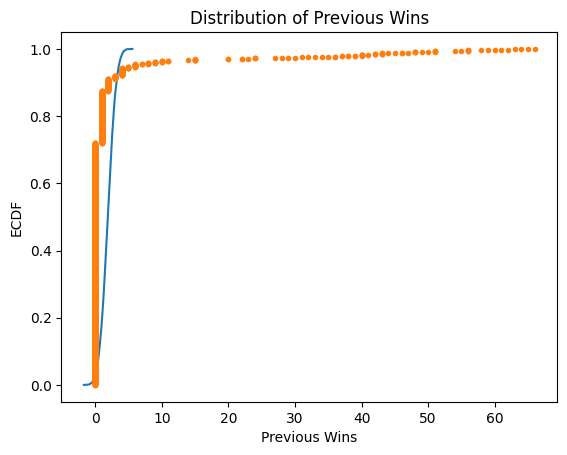

In [1662]:
#Distribution of prev_wins
mean = np.mean(prop['prev_wins'])
samples = rng.normal(mean, size=10000)
x, y  = ecdf(prop['prev_wins'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Previous Wins')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Previous Wins')
plt.show()

The values are almost all 0 (70+%) or 1 (15+%). Given this, it would be better to turn this variable into a flag for whether the client is a repeat client

In [1663]:
prop.loc[prop['prev_wins'] > 0, 'prev_wins'] = 1

In [1664]:
prop['prev_wins'].value_counts()

,count
prev_wins,
0.000000,1647
1.000000,640


Surprisingly little overlap between prev_wins and prev_rfs. The prev_rfs column should be considered more accurate since it is checked and entered manaually for each proposal. The prev_wins column ay be off due to it only being based on what is in this file, which starts in 2019. Given this, we will disregard the prev_wins columns

In [1665]:
pd.crosstab(prop['prev_rfs'], prop['prev_wins'], dropna=False)

prev_wins,0.000000,1.000000
prev_rfs,,
-,1,2
No,1210,395
Yes,436,243


# **townhouse_flag - discard (use building_type instead)**

This flag indicates whether the building the proposal relates to is a townhouse

The townhouse flag seems to be used mostly for rfs project types. Need to clarify if this is by ommission or reflects reality

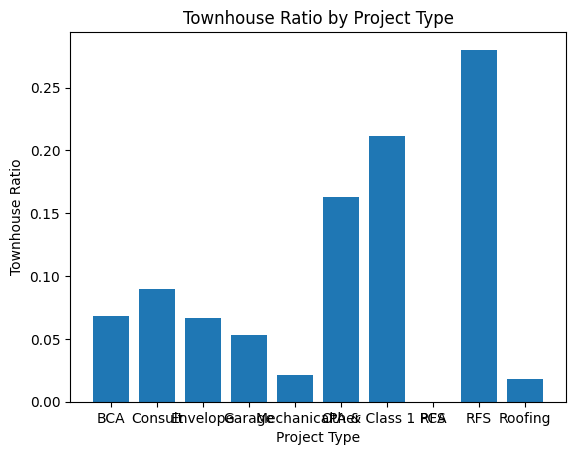

In [1666]:
townhouse_ratio = prop.groupby('project_type')['townhouse_flag'].mean()

#create a chart that displays the townhouse_ratio
fig, ax = plt.subplots()
ax.bar(townhouse_ratio.index, townhouse_ratio.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Townhouse Ratio')
ax.set_title('Townhouse Ratio by Project Type')
plt.show()

At first glance, even within the RFS project type, the townhouse flag seems to have little impact

In [1667]:
rfs.groupby('townhouse_flag')['outcome'].mean()

,outcome
townhouse_flag,
0.000000,0.456140
1.000000,0.461538


In [1668]:
#convert the flag from float to int
rfs['townhouse_flag'] = rfs['townhouse_flag'].astype(int)
prop['townhouse_flag'] = prop['townhouse_flag'].astype(int)

<ipython-input-1668-8cb652061732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfs['townhouse_flag'] = rfs['townhouse_flag'].astype(int)


Hypothesis: townhouse_flag has no impact on outcome for RFS projects

In [1669]:
sample_a = rfs[rfs['townhouse_flag'] == 1]['outcome']
sample_b = rfs[rfs['townhouse_flag'] == 0]['outcome']

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.4476


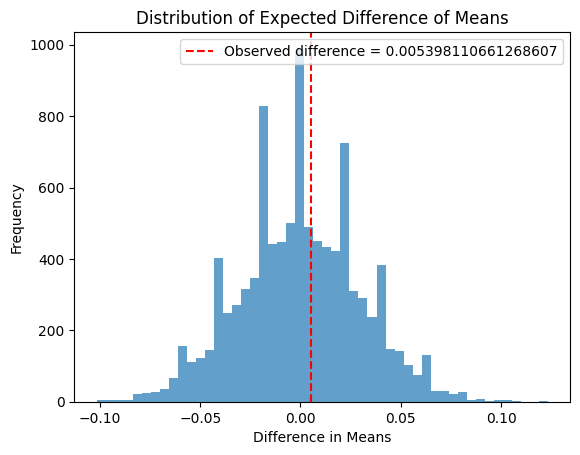

In [1670]:
import matplotlib.pyplot as plt
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

The townhouse_flag doesn't seem to make a significant difference to the win ratio even within the RFS project type. The p-value is moderately low at 0.22, so there is a chance there is still a chance there is something here. The team lead said they are well known for their townhouse work, so I'm going to leave this feature in for the sake of further exploration.

# **storeys - discard**

This column indicates how many storeys are in the building that the proposal relates to.

Basic exploration

There are a lot of missing values in this column (1361 nulls vs 930 non-null).

In [1671]:
print(prop['storeys'].describe())

print('# of nulls: ', prop['storeys'].isnull().sum())

count   930.000000
mean     11.124731
std      24.556070
min       1.000000
25%       3.000000
50%       5.000000
75%      15.000000
max     637.000000
Name: storeys, dtype: float64
# of nulls:  1357


RFS is the only project_type where the storeys column seems to be used. It is still null for over 40% of the RFS proposals though. Need to explore whether there is a pattern to when it is used. Building types like townhouses may not have storeys

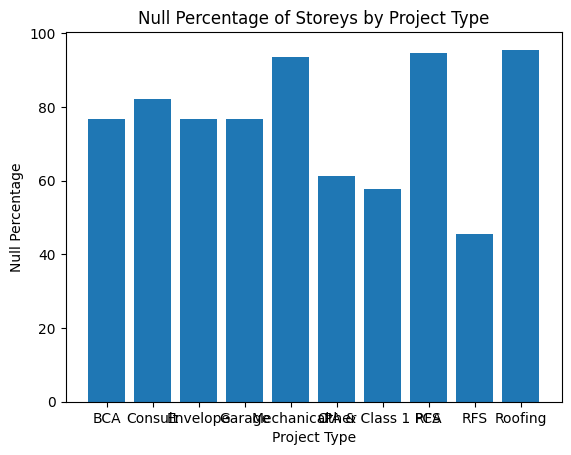

In [1672]:
#chart of % of nulls in storey by project_type
null_percentage = prop.groupby('project_type')['storeys'].apply(lambda x: x.isnull().mean()) * 100

fig, ax = plt.subplots()
ax.bar(null_percentage.index, null_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt.title('Null Percentage of Storeys by Project Type')
plt.show()

Buildings that are townhouses and POTLS usually do not have data on storeys. This makes sense since these buildings are almost never high-rises. Commercial buildings do often have storey information though

In [1673]:
print(rfs.groupby('townhouse_flag')['storeys'].apply(lambda x: x.isnull().mean()) * 100)
print(rfs.groupby('comm_flag')['storeys'].apply(lambda x: x.isnull().mean()) * 100)

rfs['potl_flag'] = rfs['potl_units'].apply(lambda x: 1 if x > 0 else 0)

print(rfs.groupby('potl_flag')['storeys'].apply(lambda x: x.isnull().mean()) * 100)

townhouse_flag
0   34.984520
1   72.148541
Name: storeys, dtype: float64
comm_flag
0.000000   47.899160
1.000000   26.282051
Name: storeys, dtype: float64
potl_flag
0    41.620334
1   100.000000
Name: storeys, dtype: float64


<ipython-input-1673-da4feb5baa4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfs['potl_flag'] = rfs['potl_units'].apply(lambda x: 1 if x > 0 else 0)


Townhouses & POTLS are usually regular residences, so we can likely interpolate the storeys for these

Townhouses are prodominently 2 storeys, which makes sense. We'll apply this as the storeys value for all null townhouses

In [1674]:
rfs[rfs['townhouse_flag'] == 1]['storeys'].describe()

,storeys
count,105.000000
mean,4.190476
std,7.189864
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,57.000000


There is no storey information to look at for POTLS, but these are usually detached residential homes, so we will assume these are 2 storeys as well

In [1675]:
rfs.loc[(rfs['potl_flag'] == 1) & (rfs['storeys'].isnull()), 'storeys'] = 2

**Outliers**

There are some very clear outliers. The tallest skyscraper in Ontario is 78 storeys (excluding the CN tower), so these must be errors

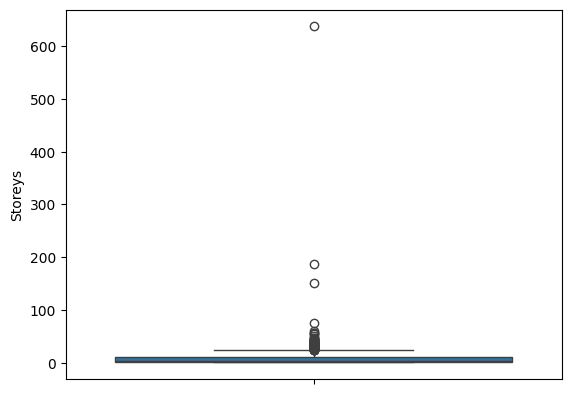

In [1676]:
#boxplot of storeys from rfs_storeys
_ = sns.boxplot(y='storeys', data = rfs)
_ = plt.ylabel('Storeys')

In [1677]:
#set any storeys values that are over 78 to null
rfs.loc[rfs['storeys'] > 78, 'storeys'] = np.nan
prop.loc[prop['storeys'] > 78, 'storeys'] = np.nan

There are still quite a few nulls in storeys. This feature may not be useable since we can't reasonably try to predict the value to fill in the NaNs

In [1678]:
#nulls in storeys
print('nulls: ', rfs['storeys'].isnull().sum())
print('not null: ', rfs['storeys'].notnull().sum())

nulls:  527
not null:  819


**Distribution**

Storeys can be described only after nulls, townhouses and potls are removed. This is a small subset so the feature may not be useable

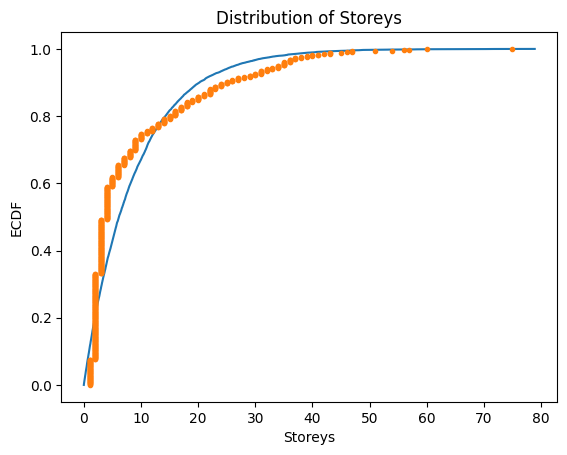

In [1679]:
#Exponential Distribution
rfs_nona = rfs.dropna(subset=['storeys'])

rng = np.random.default_rng()

mean = np.mean(rfs_nona['storeys'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(rfs_nona['storeys'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Storeys')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Storeys')
plt.show()

It looks like all of the 2 storeys for townhouses and potls are creating a large cluster. Lets remove those and see what it looks like

In [1680]:
#remove records where townhouse_flag or potl_flag = 1
rfs_storeys = rfs[~((rfs['townhouse_flag'] == 1) | (rfs['potl_flag'] == 1))]

The distribution is very close to exponential when nulls, townhouses and potls are removed.

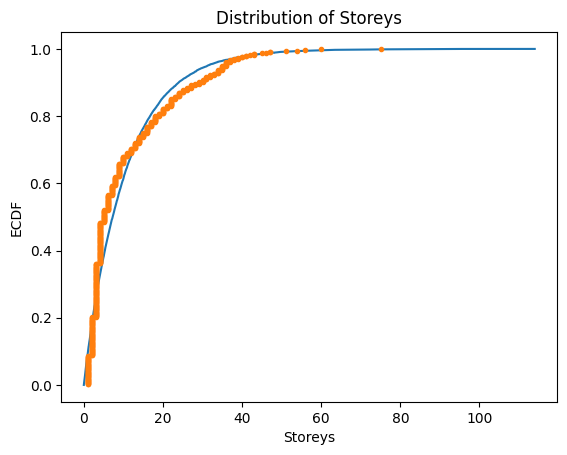

In [1681]:
#Exponential
rfs_storeys_nona = rfs_storeys.dropna(subset=['storeys'])

rng = np.random.default_rng()

mean = np.mean(rfs_storeys_nona['storeys'])
samples = rng.exponential(mean, size=10000)
x, y  = ecdf(rfs_storeys_nona['storeys'])
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker = '.', linestyle = 'none')
_ = plt.xlabel('Storeys')
_ = plt.ylabel('ECDF')
_ = plt.title('Distribution of Storeys')
plt.show()

In [1682]:
print('Of the rfs projects that are not Townhouses or POTLS:')
print('nulls: ', rfs_storeys['storeys'].isnull().sum())
print('not null: ', rfs_storeys['storeys'].notnull().sum())

Of the rfs projects that are not Townhouses or POTLS:
nulls:  255
not null:  627


**Collinearity**

The storeys column is likely correlated with the region. Would expect to see higher stories in the TOR region

The TOR region does have most of the larger storied buildings.

In [1683]:
rfs_storeys.groupby('region')['storeys'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
EO,73.000000,5.493151,6.011848,1.000000,3.000000,3.000000,5.000000,29.000000
GH,26.000000,4.730769,2.290113,1.000000,4.000000,4.000000,5.500000,12.000000
GR,6.000000,3.833333,2.041241,2.000000,2.000000,3.500000,5.750000,6.000000
HUR,59.000000,3.338983,1.987983,1.000000,2.000000,3.000000,4.000000,15.000000
LON,4.000000,5.000000,1.154701,4.000000,4.000000,5.000000,6.000000,6.000000
TOR,451.000000,12.917960,12.625544,1.000000,3.000000,8.000000,20.000000,75.000000
Unknown,6.000000,3.833333,4.262237,1.000000,1.000000,2.500000,4.000000,12.000000
WIN,2.000000,14.000000,0.000000,14.000000,14.000000,14.000000,14.000000,14.000000


Given the relation with region which we know will be an important feature, the large number of nulls, and the limited applicability of this column, we'll won't be bringing it forward into the analysis

# **building_type - keep**

The columns potl_flag, townhouse_flag, comm_flag all relate to different building types. We may want to combine these into one categorical feature

In [1684]:
#start with assigning potl and townhouse since they are easy 1 to 1
prop['building_type'] = prop['potl_units'].apply(lambda x: 'potl' if x > 0 else 'unknown')
prop.loc[prop['townhouse_flag'] == 1, 'building_type'] = 'townhouse'

In [1685]:
#comm_flag can sometimes be applied to mixed use buildings, so we need to look for residential and comm units
prop.loc[(prop['comm_flag'] == 1) & (prop['res_units'] > 0), 'building_type'] = 'mixed_use'
prop.loc[(prop['comm_flag'] == 1) & (prop['building_type'] == 'unknown'), 'building_type'] = 'commercial'

In [1686]:
#set any remaining that have storeys > 3 to highrise
prop.loc[(prop['storeys'] > 3) & (prop['building_type'] == 'unknown'), 'building_type'] = 'highrise'

In [1687]:
#Set any 'none' with res_units > 0 and storeys > 0 to 'residential'
prop.loc[(prop['res_units'] > 0) & (prop['building_type'] == 'unknown') & (prop['storeys'] > 0), 'building_type'] = 'residential'

In [1688]:
prop['building_type'].value_counts(dropna=False)

,count
building_type,
unknown,894
highrise,488
townhouse,449
residential,161
commercial,142
potl,116
mixed_use,37


There are a lot of entries we haven't been able to classify. Lets break it down

As expected there are a lot less nulls within the RFS project_type, but still enough for it to be an issue

project_type
BCA                75.342466
Consult            74.736842
Envelope           70.860927
Garage             72.340426
Mechanical         89.361702
Other              54.081633
PA & Class 1 RFS    8.235294
PCA                97.826087
RFS                16.939079
Roofing            91.891892
Name: building_type, dtype: float64


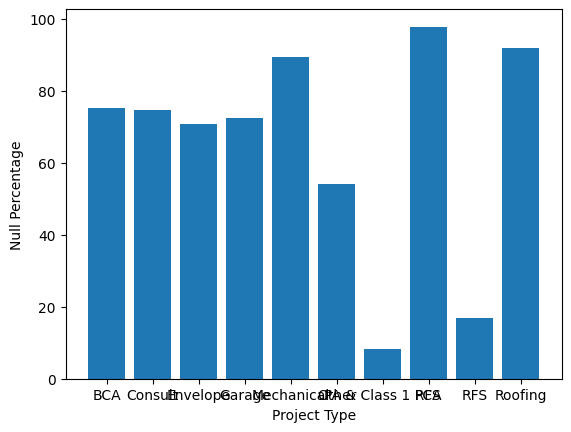

In [1689]:
#% of 'none' by project_type
none_percentage = prop.groupby('project_type')['building_type'].apply(lambda x: (x == 'unknown').mean()) * 100

fig, ax = plt.subplots()
ax.bar(none_percentage.index, none_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt

print(none_percentage)

Taking a look at rows that aren't being captured there are a lot classified as industrial. We'll add these to the commercial classification

In [1690]:
#view 10 rows where building_type is none and project_type is rfs
pd.set_option('display.max_colwidth', None)
prop[(prop['building_type'] == 'unknown') & (prop['project_type'] == 'RFS')].head(20)

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,storeys,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region,building_type
0,Q191859,TS,Update RFS,0,NaN,NaN,NaN,NaN,Yes,No,...,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q1,TOR,unknown
3,Q200480,TC,Class 3 RFS,0,NaN,NaN,NaN,NaN,Yes,No,...,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q2,Unknown,unknown
5,Q200554,SC,Class 3 RFS,0,48,NaN,NaN,1,Yes,No,...,NaN,0.000000,NaN,NaN,48.000000,49.000000,RFS,2019Q2,HUR,unknown
6,Q200558,TS,Class 1 RFS,0,NaN,NaN,NaN,2,No,No,...,NaN,0.000000,NaN,NaN,NaN,49.000000,RFS,2019Q2,TOR,unknown
10,Q200345,MT,Class 2 RFS,0,-,-,-,-,Yes,No,...,NaN,0.000000,NaN,NaN,NaN,18.000000,RFS,2019Q2,TOR,unknown
11,Q200514,YR,Class 2 RFS,0,189,NaN,-,3?,No,No,...,NaN,0.000000,NaN,NaN,189.000000,49.000000,RFS,2019Q2,TOR,unknown
12,Q200531,YR,Class 2 RFS,0,93,NaN,-,3?,No,No,...,NaN,0.000000,NaN,NaN,93.000000,49.000000,RFS,2019Q2,TOR,unknown
13,Q200518,YR,Class 2 RFS,0,158,NaN,-,3?,Yes,No,...,NaN,0.000000,NaN,NaN,158.000000,49.000000,RFS,2019Q2,TOR,unknown
14,Q200525,YR,Class 2 RFS,0,440,NaN,-,3?,No,No,...,NaN,0.000000,NaN,NaN,440.000000,NaN,RFS,2019Q2,TOR,unknown
15,NaN,TS,Class 1 RFS,0,NaN,NaN,NaN,NaN,No,No,...,NaN,0.000000,NaN,NaN,NaN,NaN,RFS,2019Q2,TOR,unknown


In [1691]:
#return top 20 rows where units_orig contains the string 'ind'
prop[prop['units_orig'].str.contains('ind', case=False, na=False)].head(10)

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,storeys,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region,building_type
164,Q201596,PC,Update RFS,0,7 Industrial Buildings,-,-,-,Yes,Yes,...,NaN,0.000000,7.000000,NaN,NaN,49.000000,RFS,2019Q4,TOR,unknown
165,Q201598,YR,Update RFS,0,12 Industrial,1,-,-,Yes,Yes,...,1.000000,0.000000,12.000000,NaN,NaN,49.000000,RFS,2019Q4,TOR,unknown
168,Q201659,YR,Update RFS,0,10 Industrial,1,-,-,Yes,Yes,...,1.000000,0.000000,10.000000,NaN,NaN,NaN,RFS,2019Q4,TOR,unknown
191,Q201817,TS,Update RFS,0,5 comm/ind,-,-,-,Yes,Yes,...,NaN,1.000000,5.000000,NaN,NaN,49.000000,RFS,2019Q4,TOR,commercial
211,Q201552,YR,Class 2 RFS,0,47 Comm/Ind,1,-,-,Yes,Yes,...,1.000000,1.000000,47.000000,NaN,NaN,49.000000,RFS,2019Q4,TOR,commercial
213,Q201810,YR,Update RFS,0,114 Comm/Ind,5,-,2,Yes,Yes,...,5.000000,1.000000,114.000000,NaN,NaN,49.000000,RFS,2019Q4,TOR,commercial
224,Q201980,YR,Class 2 RFS,0,12 Industrial,-,-,-,No,No,...,NaN,0.000000,12.000000,NaN,NaN,49.000000,RFS,2019Q4,TOR,unknown
307,Q210108,YR,Class 2 RFS,0,47 Comm/Ind,1,-,-,No,No,...,1.000000,1.000000,47.000000,NaN,NaN,50.000000,RFS,2020Q2,TOR,commercial
318,Q210134,TS,Class 2 RFS,0,30 Comm/Ind,6,-,-,No,No,...,6.000000,1.000000,30.000000,NaN,NaN,5.000000,RFS,2020Q2,TOR,commercial
322,Q210154,HC,Update RFS,0,158 Comm/Ind,4,-,-,Yes,Yes,...,4.000000,1.000000,158.000000,NaN,NaN,4.000000,RFS,2020Q2,GH,commercial


In [1692]:
#Anywhere where building_type = none and units_orig contains 'ind', set building type to commercial
prop.loc[(prop['building_type'] == 'unknown') & (prop['units_orig'].str.contains('ind', case=False, na=False)), 'building_type'] = 'commercial'

In [1693]:
prop['building_type'].value_counts(dropna=False)

,count
building_type,
unknown,883
highrise,488
townhouse,449
residential,161
commercial,153
potl,116
mixed_use,37


There also seems to be a gap where the storeys column is null. Lets see if we can use unit_count to classify in these cases

In [1694]:
#create a combined units column that adds the three other unit columns together
prop['units'] = (prop['res_units'].fillna(0) +
                 prop['comm_units'].fillna(0) +
                 prop['potl_units'].fillna(0))

#set any 0s in the units column to nulls
prop.loc[prop['units'] == 0, 'units'] = np.nan

# Check the summary statistics
print(prop['units'].describe())

count   1517.000000
mean     105.411338
std      134.234361
min        1.000000
25%       24.000000
50%       49.000000
75%      133.000000
max     1343.000000
Name: units, dtype: float64


In [1695]:
#Units for null storeys and Unknown building_type
prop[prop['storeys'].isnull() & (prop['building_type'] == 'unknown')]['units'].describe()

,units
count,162.000000
mean,123.024691
std,183.533907
min,3.000000
25%,28.750000
50%,54.500000
75%,144.750000
max,1343.000000


In [1696]:
#Units for highrise building type
prop[prop['building_type'] == 'highrise']['units'].describe()

,units
count,472.000000
mean,188.906780
std,151.522408
min,3.000000
25%,68.750000
50%,147.000000
75%,283.250000
max,1012.000000


In [1697]:
#Units for townhouse building type
prop[prop['building_type'] == 'townhouse']['units'].describe()

,units
count,418.000000
mean,58.918660
std,61.017889
min,4.000000
25%,23.250000
50%,40.000000
75%,74.750000
max,548.000000


In [1698]:
#Units for potl building types
prop[prop['building_type'] == 'potl']['units'].describe()

,units
count,116.000000
mean,50.586207
std,43.205489
min,2.000000
25%,21.000000
50%,40.000000
75%,66.250000
max,224.000000


In [1699]:
#Units for commercial building types
prop[prop['building_type'] == 'commercial']['units'].describe()

,units
count,151.000000
mean,32.039735
std,38.500715
min,1.000000
25%,12.000000
50%,21.000000
75%,39.000000
max,315.000000


There's almost no overlap in unit count between highrises and the other building types which makes sense. We will assume anything with a unit count above 68 is a highrise (25th percentile for highrise)

In [1700]:
prop.loc[(prop['building_type'] == 'unknown') & (prop['units'] > 75), 'building_type'] = 'highrise'

In [1701]:
prop[prop['project_type'] == 'RFS']['building_type'].value_counts(dropna=False)

,count
building_type,
highrise,407
townhouse,375
unknown,170
residential,141
commercial,137
potl,87
mixed_use,29


project_type
BCA                75.342466
Consult            70.000000
Envelope           70.198675
Garage             69.148936
Mechanical         87.234043
Other              50.000000
PA & Class 1 RFS    5.882353
PCA                97.826087
RFS                12.630015
Roofing            91.891892
Name: building_type, dtype: float64


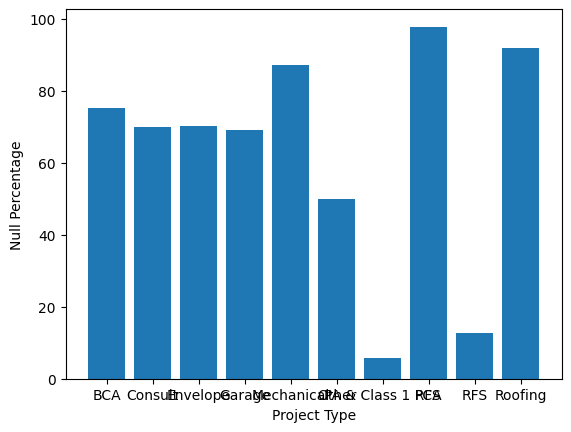

In [1702]:
#% of 'none' by project_type
none_percentage = prop.groupby('project_type')['building_type'].apply(lambda x: (x == 'unknown').mean()) * 100

fig, ax = plt.subplots()
ax.bar(none_percentage.index, none_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt

print(none_percentage)

With 12% nulls within the RFS project_type, we can use this column if it is impactful. I'm unsure of the residential flag though. **Lets ask the team about this to confirm we're classifying correctly**

**Impact**

Does the building_type column impact outcome for RFS projects?

In [1703]:
rfs = prop[prop['project_type'] == 'RFS']

In [1704]:
rfs['building_type'].value_counts()

,count
building_type,
highrise,407
townhouse,375
unknown,170
residential,141
commercial,137
potl,87
mixed_use,29


At a high-level there does seem to be an impact

In [1705]:
rfs.groupby('building_type')['outcome'].mean()

,outcome
building_type,
commercial,0.569343
highrise,0.415233
mixed_use,0.310345
potl,0.528736
residential,0.531915
townhouse,0.458667
unknown,0.394118


Commercial and Highrise building_types have a large difference in mean outcome, so lets test these ones

There is definitely seems to be something here! We'll keep this column for further exploration

In [1706]:
sample_a = rfs[rfs['building_type'] == 'commercial']['outcome']
sample_b = rfs[rfs['building_type'] == 'highrise']['outcome']

empirical_diff_means = diff_of_means(sample_a, sample_b)
perm_replicates = draw_perm_reps(sample_a, sample_b, diff_of_means, size=10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', round(p, 4))

p-value = 0.0014


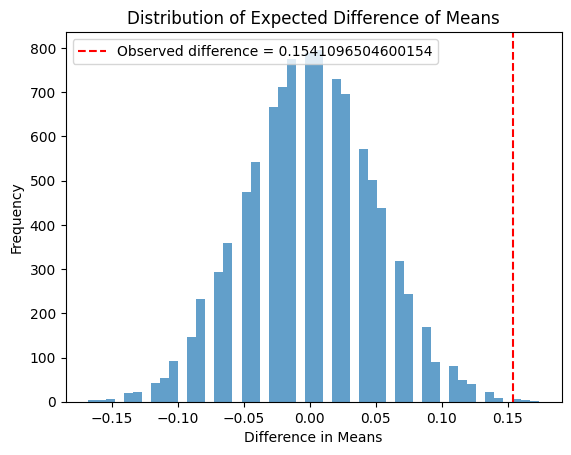

In [1707]:
plt.hist(perm_replicates, bins=50, alpha=0.7)
plt.axvline(empirical_diff_means, color='red', linestyle='--', label=f'Observed difference = {empirical_diff_means}')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Difference of Means')
plt.legend()
plt.show()

# **units - keep**

This is the number of units in a building or collection of buildings that the proposal pertains to.

**Nulls**

There is a fairly high number of nulls in this column

In [1708]:
print('nulls: ', prop['units'].isnull().sum())
print('not null: ', prop['units'].notnull().sum())

nulls:  770
not null:  1517


Once again it looks like this column is only dependable for the RFS project type

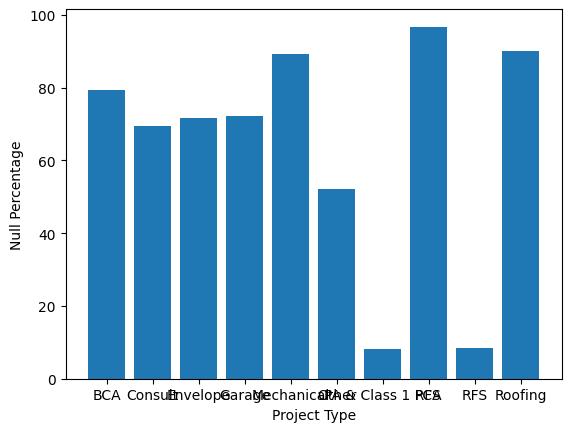

project_type
BCA                79.452055
Consult            69.473684
Envelope           71.523179
Garage             72.340426
Mechanical         89.361702
Other              52.040816
PA & Class 1 RFS    8.235294
PCA                96.739130
RFS                 8.543834
Roofing            90.090090
Name: units, dtype: float64


In [1709]:
#% of nulls by project_type
null_percentage = prop.groupby('project_type')['units'].apply(lambda x: x.isnull().mean()) *100

fig, ax = plt.subplots()
ax.bar(null_percentage.index, null_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt.show()

print(null_percentage)

In [1710]:
rfs = prop[prop['project_type'] == 'RFS']

#set any 0s in the units column to nulls
rfs.loc[rfs['units'] == 0, 'units'] = np.nan
prop.loc[prop['units'] == 0, 'units'] = np.nan

The nulls within RFS seem to be mostly found in building types that are unknown. There is a small number of nulls so this column is useable

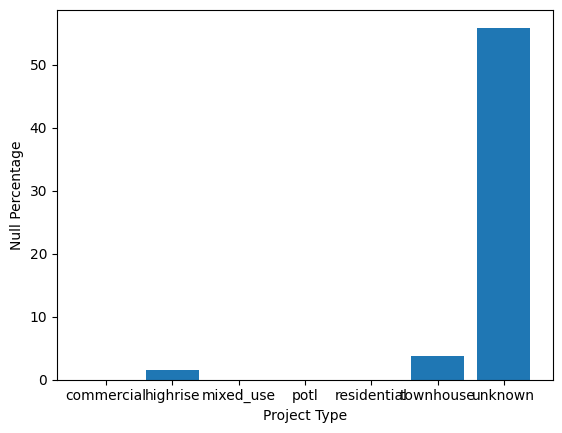

building_type
commercial     0.000000
highrise       1.474201
mixed_use      0.000000
potl           0.000000
residential    0.000000
townhouse      3.733333
unknown       55.882353
Name: units, dtype: float64


In [1711]:
#% nulls in units by building_type
null_percentage = rfs.groupby('building_type')['units'].apply(lambda x: x.isnull().mean()) *100

fig, ax = plt.subplots()
ax.bar(null_percentage.index, null_percentage.values)
ax.set_xlabel('Project Type')
ax.set_ylabel('Null Percentage')
plt.show()

print(null_percentage)

**Distribution**

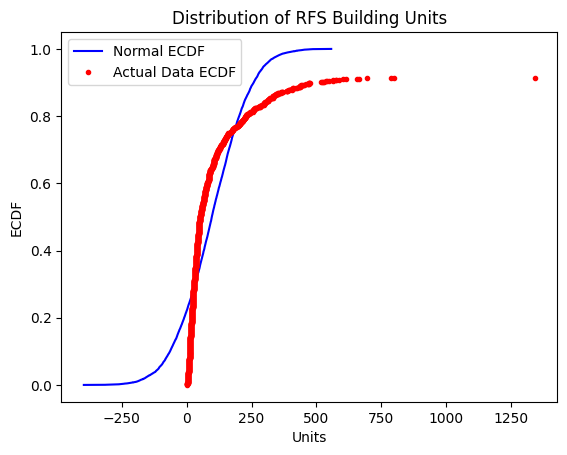

In [1712]:
#Normal Distribution
units = rfs['units']
std = np.std(units)
mean = np.mean(units)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(units)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Units')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Building Units')
plt.legend()
plt.show()

Lets try breaking this up by building_type

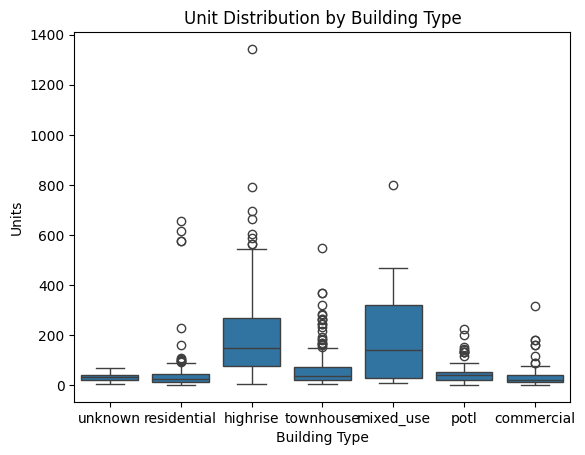

In [1713]:
#boxplot of units by building_type
_ = sns.boxplot(x='building_type', y='units', data = rfs)
_ = plt.ylabel('Units')
_ = plt.xlabel('Building Type')
_ = plt.title('Unit Distribution by Building Type')
plt.show()

The residential bucket seems a bit odd - should these outliers be classified as highrise?

Most of these high-unit residential buildings look to be highrises that had an original storeys value that was too complex to parse correctly. The storeys column is what we used to define highrise

In [1714]:
rfs[(rfs['building_type'] == 'residential') & (rfs['units'] > 200)].head(20)

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region,building_type,units
112,Q201221,PC,Update RFS,0,616,2,-,-,Yes,No,...,0.000000,NaN,NaN,616.000000,10.000000,RFS,2019Q3,TOR,residential,616.000000
522,Q212057,PC,Class 2 RFS,0,228,2,-,-,No,No,...,0.000000,NaN,NaN,228.000000,41.000000,RFS,2020Q4,TOR,residential,228.000000
735,Q220913,TS,Update RFS,0,575,27\n23\nconnectected by 3-storey podium,-,2,Yes,No,...,0.000000,NaN,NaN,575.000000,4.000000,RFS,2021Q2,TOR,residential,575.000000
1387,PCC-231821-00,TS,Class 2 RFS,0,657,1,-,4,No,No,...,0.000000,NaN,NaN,657.000000,18.000000,RFS,2022Q3,TOR,residential,657.000000
2185,PCC-252059-00,TS,Class 2 RFS,0,575,27\n23\nconnectected by 3-storey podium,-,2,Yes,No,...,0.000000,NaN,NaN,575.000000,7.000000,RFS,2024Q2,TOR,residential,575.000000


Highrise

This distribution is better but still not a fit

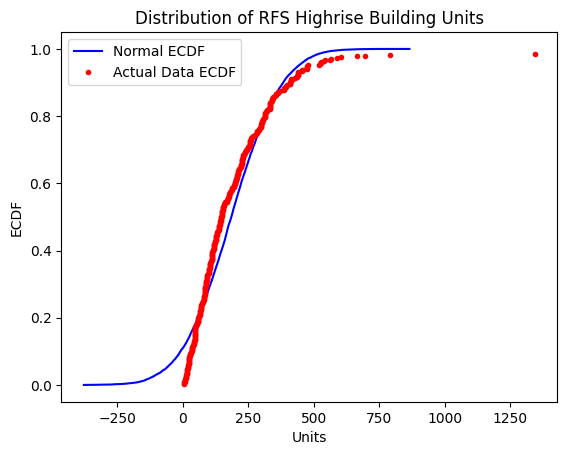

In [1715]:
#Normal Distribution
units = rfs[rfs['building_type'] == 'highrise']['units']
std = np.std(units)
mean = np.mean(units)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(units)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Units')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Highrise Building Units')
plt.legend()
plt.show()

Definitely not normally distributed

In [1716]:
units_clean = rfs[rfs['building_type'] == 'highrise']['units'].dropna()
stat, p_value = shapiro(units_clean)
print(f"Shapiro-Wilk Test Statistic: {stat}, P-value: {p_value:.4f}")

Shapiro-Wilk Test Statistic: 0.8645988229883343, P-value: 0.0000


Townhouse

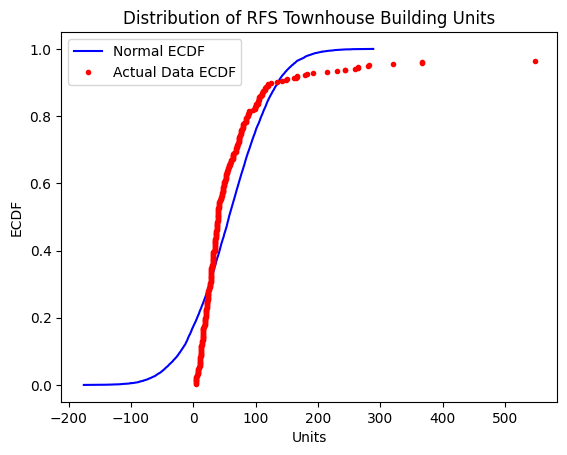

In [1717]:
#Normal Distribution
units = rfs[rfs['building_type'] == 'townhouse']['units']
std = np.std(units)
mean = np.mean(units)

samples = np.random.normal(mean, std, size=10000)

ecdf_actual = ECDF(units)
ecdf_samples = ECDF(samples)

x, y = ecdf_actual.x, ecdf_actual.y
x_theor, y_theor = ecdf_samples.x, ecdf_samples.y

plt.plot(x_theor, y_theor, label='Normal ECDF', linestyle='-', color='blue')
plt.plot(x, y, label='Actual Data ECDF', marker='.', linestyle='none', color='red')
plt.xlabel('Units')
plt.ylabel('ECDF')
plt.title('Distribution of RFS Townhouse Building Units')
plt.legend()
plt.show()

Some of these values are suspiciously high but they actually look legitimate

In [1718]:
rfs[(rfs['building_type'] == 'townhouse') & (rfs['units'] > 200)].head(10)

,proposal_num,registry_region,sow,rfp,units_orig,storeys_orig,townhouse_orig,parking_orig,prev_rfs,reminder,...,comm_flag,comm_units,potl_units,res_units,building_age,project_type,quarter,region,building_type,units
60,Q200794,OC,Class 2 RFS,0,214,2,2,-,No,No,...,0.000000,NaN,NaN,214.000000,40.000000,RFS,2019Q3,EO,townhouse,214.000000
228,Q202007,PC,Update RFS,0,280,23,2,2,Yes,Yes,...,0.000000,NaN,NaN,280.000000,50.000000,RFS,2020Q1,TOR,townhouse,280.000000
411,Q210557,YC,Class 2 RFS,0,548,2,47,-,No,Yes,...,0.000000,NaN,NaN,548.000000,44.000000,RFS,2020Q3,TOR,townhouse,548.000000
474,Q211514,HC,Update RFS,0,264,4,10,1,Yes,No,...,0.000000,NaN,NaN,264.000000,3.000000,RFS,2020Q3,GH,townhouse,264.000000
499,Q211727,YC,Class 2 RFS,0,243,9 + TH,8,1,Yes,Yes,...,0.000000,NaN,NaN,243.000000,43.000000,RFS,2020Q3,TOR,townhouse,243.000000
516,Q212020,TS,Update RFS,0,260,2 x 12,1,3,Yes,Yes,...,0.000000,NaN,NaN,260.000000,17.000000,RFS,2020Q4,TOR,townhouse,260.000000
847,PCC-222276-00,PC,Class 2 RFS,0,230,-,16,-,Yes,Yes,...,0.000000,NaN,NaN,230.000000,29.000000,RFS,2021Q3,TOR,townhouse,230.000000
1588,PCC-233723-00,PC,Class 2 RFS,0,367,31,1 block,2 upper SF\n2 lower SF,No,No,...,0.000000,NaN,NaN,367.000000,17.000000,RFS,2023Q1,TOR,townhouse,367.000000
1589,PCC-233724-00,PC,Class 2 RFS,0,367,31,1 block,2 upper SF\n2 lower SF,No,No,...,0.000000,NaN,NaN,367.000000,17.000000,RFS,2023Q1,TOR,townhouse,367.000000
1826,PCC-241777-00,HC,Update RFS,0,264,-,10,1,Yes,No,...,0.000000,NaN,NaN,264.000000,6.000000,RFS,2023Q3,GH,townhouse,264.000000


I'm not able to describe the units distribution well. I suspect it is important though since it my only indicator of building size

Lets try **bucketing**

Highrise

We'll start by creating very basic bins

In [1726]:
#create 10 bins for the building_type = highrise units
rfs.loc[rfs['building_type'] == 'highrise', 'units_bin'] = pd.cut(
    rfs[rfs['building_type'] == 'highrise']['units'], bins=10
)

<ipython-input-1726-c380683dfda5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfs.loc[rfs['building_type'] == 'highrise', 'units_bin'] = pd.cut(


In [1731]:
rfs[rfs['building_type']=='highrise'].groupby('units_bin')['outcome'].agg(['count', 'mean'])

<ipython-input-1731-ea3eb138008c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfs[rfs['building_type']=='highrise'].groupby('units_bin')['outcome'].agg(['count', 'mean'])


,count,mean
units_bin,,
"(1.66, 137.0]",187,0.497326
"(137.0, 271.0]",115,0.321739
"(271.0, 405.0]",61,0.393443
"(405.0, 539.0]",29,0.344828
"(539.0, 673.0]",6,0.333333
"(673.0, 807.0]",2,0.000000
"(807.0, 941.0]",0,NaN
"(941.0, 1075.0]",0,NaN
"(1075.0, 1209.0]",0,NaN


Based on this there could be fluctuations in outcome related to unit count. We'll bring this freature through to explore how to better use it

# **issued_date - discard**

This is the date that the proposal was sent out to the client

**Nulls**

In [1720]:
print('nulls: ', prop['issued_date'].isnull().sum())
print('not null: ', prop['issued_date'].notnull().sum())

nulls:  60
not null:  2227


There are very few nulls. If this is null, we will assume it was not sent out. We will remove any row with a null

In [1721]:
#drop rows where issued_date is null
prop.dropna(subset=['issued_date'], inplace=True)

**Impact**

In [1722]:
#create quarter column
prop['quarter'] = prop['issued_date'].dt.to_period('Q')

The overall win rate has generally increased over time. At the begining of 2022 we saw the win rate go up.

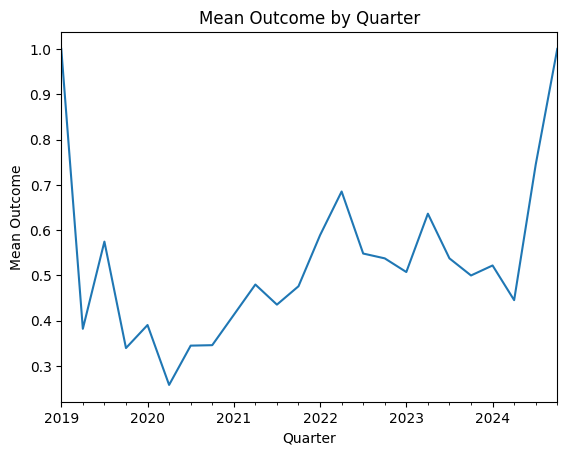

In [1723]:
#mean outcome over time
prop.groupby('quarter')['outcome'].mean().plot(kind='line')
plt.xlabel('Quarter')
plt.ylabel('Mean Outcome')
plt.title('Mean Outcome by Quarter')
plt.show()

Did proposal composition change around this time?

The trend in increasing project_type variety lines up very closely with the increase in outcome!

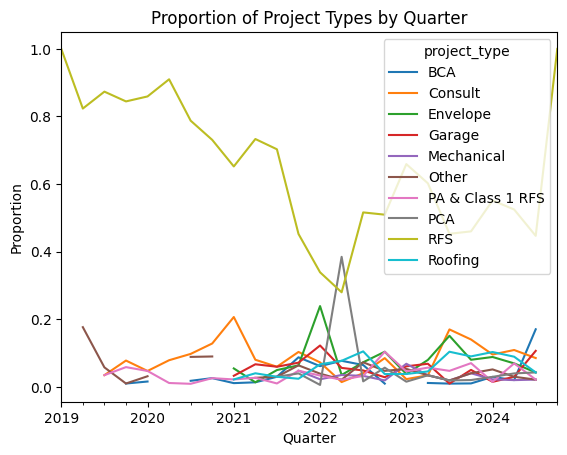

In [1724]:
#% proposals by project_type for each quarter
prop.groupby('quarter')['project_type'].value_counts(normalize=True).unstack().plot(kind='line')
plt.xlabel('Quarter')
plt.ylabel('Proportion')
plt.title('Proportion of Project Types by Quarter')
plt.show()

Since the variation in outcome over time is mostly explainable by project_type, we don't need to keep the issued_date column

# **building_age - discard**

This column indicates the age of the building that the proposal relates to at the issued_date

The distribution is definitely not normal. We will leave this feature out of our analysis

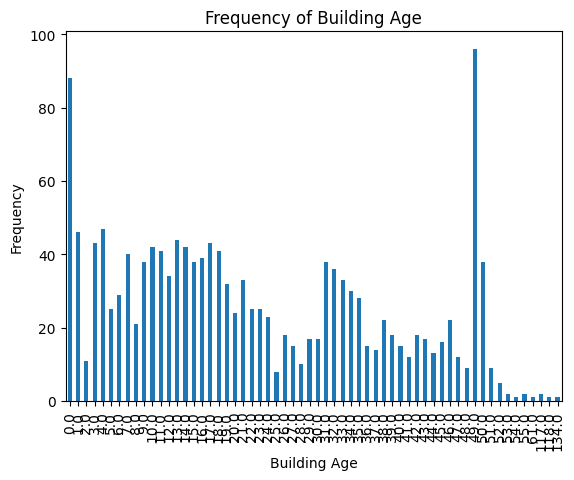

In [1725]:
age_counts = prop['building_age'].value_counts().sort_index()

age_counts.plot(kind='bar')

plt.xlabel('Building Age')
plt.ylabel('Frequency')
plt.title('Frequency of Building Age')

plt.show()

# **Collinearity**

The list of features we have selected are:

*   outcome
*   region (categorical)
*   project_type (categorical)
*   prev_rfs (binary)
*   reminder (binary)
*   building_type (categorical)
*   units (continuous but may need bucketting)









We'll start with testing the categorical features against each other

In [1733]:
def chi_squared_test(df, columns):
    results = {}

    # Generate all combinations of columns
    for col1, col2 in itertools.combinations(columns, 2):
        # Create a contingency table
        contingency_table = pd.crosstab(df[col1], df[col2])

        # Perform the Chi-squared test
        chi2, p, dof, ex = chi2_contingency(contingency_table)

        # Store the results
        results[(col1, col2)] = {
            'chi2_statistic': chi2,
            'p_value': p,
            'dof': dof
        }

    return results

**Data that is available for all project_types:**

In [1741]:
columns_to_test = ['region', 'project_type']
chi_squared_results = chi_squared_test(prop, columns_to_test)

My chi-squared results are quite large but my p-values are all 0. This seems like an error

In [1742]:
for key, value in chi_squared_results.items():
    print(f"Columns: {key}, Chi-squared: {value['chi2_statistic']:.6f}, p-value: {value['p_value']:.6f}, dof: {value['dof']}")

Columns: ('region', 'project_type'), Chi-squared: 1223.226628, p-value: 0.000000, dof: 63


**Data available only for rfs project_types:**

In [1746]:
columns_to_test = ['prev_rfs', 'reminder', 'building_type', 'region']
rfs = prop[prop['project_type'] == 'RFS']
chi_squared_results = chi_squared_test(rfs, columns_to_test)

In [1747]:
for key, value in chi_squared_results.items():
    print(f"Columns: {key}, Chi-squared: {value['chi2_statistic']:.6f}, p-value: {value['p_value']:.6f}, dof: {value['dof']}")

Columns: ('prev_rfs', 'reminder'), Chi-squared: 349.283955, p-value: 0.000000, dof: 1
Columns: ('prev_rfs', 'building_type'), Chi-squared: 23.870722, p-value: 0.000552, dof: 6
Columns: ('prev_rfs', 'region'), Chi-squared: 86.556847, p-value: 0.000000, dof: 7
Columns: ('reminder', 'building_type'), Chi-squared: 35.071909, p-value: 0.000004, dof: 6
Columns: ('reminder', 'region'), Chi-squared: 43.461012, p-value: 0.000000, dof: 7
Columns: ('building_type', 'region'), Chi-squared: 248.802887, p-value: 0.000000, dof: 42
